# <center> NLP analysis of Movie comments dataset


# Table of Contents

1. **[Functions](#1)**
2. **[General EDA](#2)**
	* [Analyzing Text Statistics](#sub-heading1)
3. **[Text Data Preprocessing](#3)**
	* [Cleaning](#sub-heading2)
	* [Tokenization](#sub-heading3)
	* [Normalisation (comparison of stemming and lemmatization)](#sub-heading4)
4. **[I variant (Stemming)](#4)**
	* [Stemming](#sub-heading)
	* [Split](#sub-heading)
	* [TFIDF](#sub-heading)
	* [Models](#sub-heading)
     + [Logistic Regression](#sub-sub-heading-1) 
     + [Compare performance of models](#sub-sub-heading-2)
        - [SGDClassifier](#sub-sub-sub-heading-1)
          * [Simple model](#sub-sub-sub-sub-heading)
          * [Hyperparameters tuning](#sub-sub-sub-sub-heading)
        - [SVM](#sub-sub-sub-heading-1)
          * [Simple model](#sub-sub-sub-sub-heading)
          * [Hyperparameters tuning](#sub-sub-sub-sub-heading)
        - [Naive Bayes (MultinomialNB )](#sub-sub-sub-heading-1)
          * [Simple model](#sub-sub-sub-sub-heading)
          * [Hyperparameters tuning](#sub-sub-sub-sub-heading)
5. **[II variant (Lemmatization)](#5)**
	* [Lemmatization](#sub-heading)
	* [Split](#sub-heading)
	* [TFIDF](#sub-heading)
	* [Models](#sub-heading)
     + [Logistic Regression](#sub-sub-heading-1) 
     + [Compare performance of models](#sub-sub-heading-2)
        - [SGDClassifier](#sub-sub-sub-heading)
            * [Simple model](#sub-sub-sub-sub-heading)
            * [Hyperparameters tuning](#sub-sub-sub-sub-heading)
        - [SVM](#sub-sub-sub-heading)
            * [Simple model](#sub-sub-sub-sub-heading)
            * [Hyperparameters tuning](#sub-sub-sub-sub-heading)
        - [Naive Bayes (MultinomialNB )](#sub-sub-sub-heading)
            * [Simple model](#sub-sub-sub-sub-heading)
            * [Hyperparameters tuning](#sub-sub-sub-sub-heading)




6. **[General conclusion](#6)**
7. **[Additional](#7)**




In [ ]:
!pip install unidecode
!pip install emoji
!pip install word2number
!pip install contractions
!pip3 install spacy
!python3 -m spacy download en_core_web_sm
!python3 -m nltk.downloader stopwords
!pip install pyspellchecker
!pip install iplot

     |████████████████████████████████| 241 kB 5.3 MB/s 
     |████████████████████████████████| 184 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=e67c9367ef6d11595975b792d63f227f065a878e5e07b07dc1166e81f28c7e93
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5580 sha256=aa8bb8e4a351f4c7aca97b717cf76cc8b817e169256b5e9731f787ca423d49c9
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number
     |████████████████████████████████| 283 kB 5.1 MB/s 
     |████████████████████████████████| 321 kB 46.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=e41851d371fa4b9aa69c5bf1fc08547404e08ee8a8b1ccd01a9e36cdcefb8419
  Stored in director

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive

import string
import emoji

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

import unidecode
from word2number import w2n
import contractions
from bs4 import BeautifulSoup
import spacy

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from spellchecker import SpellChecker
from wordcloud import WordCloud

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/DA/HW6/LargeMovieReviewDataset.csv', sep=',')

# **Functions**

**Top words**

In [ ]:
def draw_top_words(data, top_size, title):
  counting_table = pd.DataFrame(count_words(data, top_size))
  counting_table.drop([0],inplace=True)
  counting_table.columns = ['word','counting']

  plt.figure(figsize=(17,10))
  ax= sns.barplot(data=counting_table,x='word',y='counting',facecolor=(1, 1, 1, 0),edgecolor='black')
  if title == 'Top' or title == 'top':
    ax.set_title(f'Top {top_size} words'.title(),fontsize=20)
  else:
    ax.set_title(f'{title} words: Top {top_size}'.title(),fontsize=20)

  ax.set_ylabel('Word counting',fontsize=15)
  ax.set_xlabel(f'Top {top_size} words',fontsize=15);
  plt.xticks(rotation=45)
  plt.show()

**Word clouds**

In [ ]:
def draw_word_clouds(pos, neg):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
  wordcloud1 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg['review']))
  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title('Negative comment',fontsize=40);

  wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(pos['review']))
  ax2.imshow(wordcloud2)
  ax2.axis('off')
  ax2.set_title('Positive comment',fontsize=40);

**Activate Plotly**

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**Removal of html tags**

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

**Removal of whitespaces**

In [ ]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

**Removal of accented characters**

In [ ]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

**Removal of shortened words**

In [ ]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

**Removal of urls**

In [ ]:
def find_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.findall(text)

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

**Removal of Frequent words**

In [ ]:
def count_words(text, top=10):
    cnt = Counter()
    for text in text.values:
        for word in text.split():
            cnt[word] += 1
            
    return cnt.most_common(top)

In [ ]:
FREQWORDS = set([w for (w, wc) in count_words(df['review'], 10)])
FREQWORDS

{'I', 'a', 'and', 'in', 'is', 'of', 'that', 'the', 'this', 'to'}

In [ ]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in count_words(df['review'][:-n_rare_words-1:-1])])
RAREWORDS

{'/><br', 'a', 'and', 'his', 'in', 'is', 'of', 'the', 'this', 'to'}

In [ ]:
def remove_freqwords(text):
    """remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

**Removal of Rare words**

In [ ]:
def remove_rarewords(text):
    """remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

**Removal of stopwords**


In [ ]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

**Convert chat words**

In [ ]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [ ]:
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

**Convertion of emoticons**

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [ ]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

**Removal of Punctuations**

In [ ]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

**Removal of numbers**

In [ ]:
def remove_numbers(input):
  input_str = re.sub(r'\d+', "", input)
  return input_str

**Find emoji**

In [ ]:
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

**Stemming**

In [ ]:
stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text])

**Word importance**

In [ ]:
def get_word_importance(model,tfidf, top=15):

    important_tokens = pd.DataFrame(
        data=model.coef_[0],
        index=tfidf.get_feature_names(),
        columns=['Coefs']
    )

    important_tokens_pos = important_tokens.sort_values(by='Coefs', ascending=False)[:top]
    important_tokens_neg = important_tokens.sort_values(by='Coefs', ascending=False)[-top:]

    word_imp = important_tokens_pos.copy(deep=True)
    word_imp = word_imp.append(important_tokens_neg)

    plt.figure(figsize=(15,10))
    sns.barplot(x=word_imp.index, y='Coefs', data=word_imp)
    plt.title('Word importance')
    plt.xlabel('POS             vs.               NEG')
    plt.ylabel('word weight')
    plt.xticks(rotation=55)
    plt.show()

**Classification metrics**

In [ ]:
def calc_metrics(test_label, preds):
    classes_names = ['negative', 'positive']
    num_classes = 2

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

In [ ]:
classes_names = ['negative', 'positive']
num_classes = 2

**ROC AUC metric**

In [ ]:
def count_roc_auc(model, testData, test_label, num_classes, classes_names):
    preds_prob = model.predict_proba(testData)[:,1]

    classes_names = ['negative', 'positive']
    num_classes = 2
    print('ROC AUC:',
         '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
         '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

In [ ]:
def count_rocauc_classif(model, testData, test_label):
    preds_prob = model.decision_function(testData)

    classes_names = ['negative', 'positive']
    num_classes = 2
    print('ROC AUC:',
          '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
          '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

**ROC AUC cross validation**

In [ ]:
def calc_rocauc_cross_val(model, testData, test_label):
  skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

  scores = cross_val_score(model, testData, test_label, cv=skf, scoring='roc_auc')
  print('ROC AUC mean score after cross-val:   ', np.mean(scores))

  pd.Series(scores).plot()
  plt.ylabel('roc_auc')
  plt.xlabel('iteration')
  plt.title('Model')
  plt.show()

# **General EDA**

**Chech missing data**

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

**Let's look at an example of each sentiment:**  
 positive, negative

In [ ]:
# positive_text
print("Positive example :")
df[df['sentiment']=='positive']['review'].values[0]

Positive example :


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
#negative_text
print("Negative example :")
df[df['sentiment']=='negative']['review'].values[0]

Negative example :


"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

**Distribution of the Sentiment Column**

In [ ]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

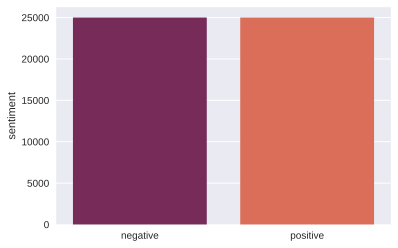

In [ ]:
sns.barplot(df['sentiment'].value_counts().index,df['sentiment'].value_counts(),palette='rocket')
plt.show()

**Conclusion**  

The graph shows that the number of positive and negative comments is equal.

## **Analyzing Text Statistics** 

We can now do some statistical analysis to explore the fundamental characteristics of the text data. Some of the analysis which can be useful are:

To perform these analysis, let us create two new features: 

- one which calculates the length of the text, and second which calculates the word count.

In [ ]:
new_df = df.copy(deep=True)

Looking at text length distribution:

In [ ]:
new_df['text_len'] = new_df['review'].astype(str).apply(len)
new_df['text_word_count'] = new_df['review'].apply(lambda x: len(str(x).split()))
new_df.head(1)

review  ... text_word_count
0  One of the other reviewers has mentioned that ...  ...             307

[1 rows x 4 columns]

In [ ]:
pos = new_df[new_df['sentiment']=='positive']
neg = new_df[new_df['sentiment']=='negative']

In [ ]:
configure_plotly_browser_state()

init_notebook_mode(connected=False)

pos['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

Output hidden; open in https://colab.research.google.com to view.

**Conclusion**

* The histogram shows that the length of not cleaned text ranges from around 1 to 12k+ characters for positive polarity and from 2 to 9000 characters for negative polarity. 

Let's see a more consolidated comparison of the relationship of text lengths with sentiment of the text.

In [ ]:
configure_plotly_browser_state()

init_notebook_mode(connected=False)

trace0 = go.Box(
    y=pos['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

Output hidden; open in https://colab.research.google.com to view.

**Conclusion**

* The biggest part of comments appear to have more or less same length. Hence, length of the text isn't a powerful indicator of the polarity.  
* However, there aresome outliers in positive comments.

**Word clouds**

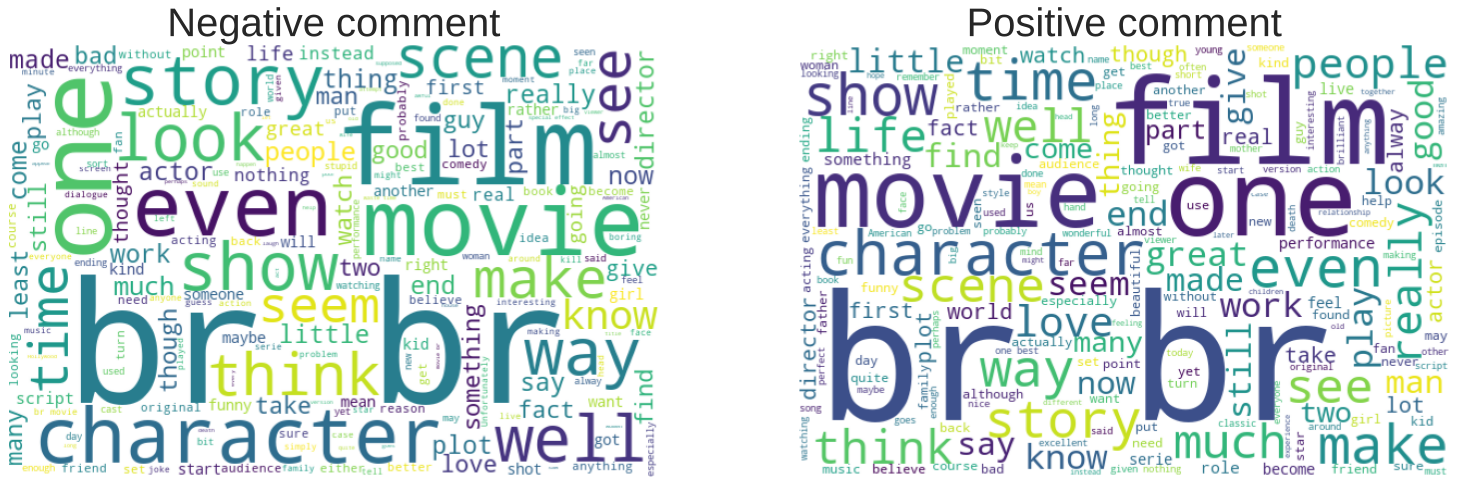

In [ ]:
draw_word_clouds(pos, neg)

**Conclusion**

* It is obvious that the text has not been processed and popular words do not yet carry a special semantic load, it is worth looking at the word clouds after processing, they should be more informative.
* br is the most frequent one. But br is a sort of HTML tag, Thus it should be removed.
* Movie or film is the theme which all reviews share. Thus I suppose idf(inverse document frequency) should be close to zero.

# **Text Data Preprocessing**

Save the original data:

In [ ]:
data = df.copy(deep=True)

Look at dataset:

In [ ]:
data.shape

(50000, 2)

In [ ]:
data.head()

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

* We can see HTML tags, numbers, abbreviations, and much more, from which should be cleared from the text.

**Check missing values**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


* No NaNs in data.

In [ ]:
data['review']= data['review'].astype("string")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  string
 1   sentiment  50000 non-null  object
dtypes: object(1), string(1)
memory usage: 781.4+ KB


## **Cleaning**

**Lower Casing**  
Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.  

This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.  

**Some other parts like:** *html removal, extra whitespaces removal are also important.*

These may not be helpful when we do tasks like Part of Speech tagging (where proper casing gives some information about Nouns and so on) and Sentiment Analysis (where upper casing refers to anger and so on)  

In [ ]:
def text_preprocessing():
    
    #remove html tags
    data['review'] = data['review'].apply(strip_html_tags)
    print('>>> REMOVE HTML TAGS <<<')
    print(data.head(1), '\n')

    #remove extra whitespaces
    data['review'] = data['review'].apply(remove_whitespace)
    print('>>> REMOVE EXTRA WHITESPACES <<<')
    print(data.head(1), '\n')

    #remove accented characters
    data['review'] =  data['review'].apply(remove_accented_chars)
    print('>>> REMOVE ACCENTED CHARS <<<')
    print(data.head(1), '\n')

    #expand contractions
    data['review'] =  data['review'].apply(expand_contractions)
    print('>>> EXPAND CONTRACTIONS <<<')
    print(data.head(1), '\n')

    #convert all characters to lowercase
    data['review'] =  data['review'].str.lower()
    print('>>> LOWERCASE <<<')
    print(data.head(1), '\n')


**Run 1st step of text preprocessing**

In [ ]:
text_preprocessing()

>>> REMOVE HTML TAGS <<<
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

**Removal of URLs**  
Next preprocessing step is to remove any URLs present in the data. Probably we might need to remove them for our further analysis.


1st of all, I check whether there are any URLs in dataset:

In [ ]:
for i in data['review']:
    url = find_urls(i)
    if url == []:
      continue
    else:
      print(url)

['www.cei.org.', 'www.cei.org/pdf/5539.pdf']
['http://www.invocus.net)']
['http://blog.myspace.com/locoformovies']
['www.softfordigging.com']
['www.petitiononline.com/19784444/petition.html']
['http://www.comingsoon.net/films.php?id=36310']
['http://tinyurl.com/znyyq']
['www.residenthazard.com)']
['http://www.zonadvd.com']
['http://imdb.com/name/nm0834754/bio']
['www.nixflix.com']
['http://rateyourmusic.com/collection/fedor8/1']
['www.abc.net.au/chaser.']
['www.lovetrapmovie.com']
['http://imdb.com/title/tt0449040/.']
['http://www.thepetitionsite.com']
['http://www.petitiononline.com/gh1215/petition.html']
['http://www.johntopping.com/harvey%20perr/war%20widow/war_widow.html']
['www.mediasickness.com']
['http://www.imdb.com/title/tt0073891/']
['www.residenthazard.com)']
['http://eattheblinds.blogspot.com/']
['http://www.imdb.com/title/tt0363163/']
['www.nixflix.com']
['www.poffysmoviemania.com)']
['http://eattheblinds.blogspot.com/']
['http://www.gutenberg.org/ebooks/18137']
['http://f

In [ ]:
data['review'] = data['review'].apply(lambda text: remove_urls(text))
data.head(1)

**Removal of Emoticons**  

There is a minor difference between emojis and emoticons.
Emoticon is built from keyboard characters that when put together in a certain way represent a facial expression, an emoji is an actual image.

:-) is an emoticon

😀 is an emoji

**!** The removal of emojis / emoticons are not always preferred and decision should be made based on the use case at hand.

* For this task, I will only remove the") " sign, since it is not always a smiley here, and I will translate the remaining emoticons into text to help the model understand the emotional coloring.

In [ ]:
data['review'] = data['review'].apply(lambda text: text.replace(')', ''))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. them city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows would not dare. forget pretty pictures painted for mainstream audiences, forget charm, forget romance...oz does not mess around. the first episode i ever saw struck me as so nasty it was surreal, i could not say i was ready for it, but as i watched more, i developed a taste for oz, and got accustomed to the high levels of graphic violence. not just violence, but injustice (crooked guards who will be sold out for a nickel, inmates who will kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz, you may become comfortable with what is uncomfortable viewing....that is if you can get in touch with your darker side.   

  sentiment  
0  positive

In [ ]:
def find_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.findall(text)

for i in data['review']:
    em = find_emoticons(i)
    if em == []:
      continue
    else:
      print(em)

['0:3']
[':3']
[':3']
['d:']
['d:']
['d:']
['d:']
['d:']
[':3', ':3', ':3', ':3', ':3', ':3']
[':-(']
[':3', ':3']
['d:', 'd:']
['d:']
['d:']
['d:']
[':b']
[':3']
[':/']
['d:']
[':3']
['d:']
['d:']
[':/']
[':']
[':']
['d:']
['d:']
['d:']
['d:']
['d:']
[':[', ':[', ':[', ':[', ':[']
['d:']
[':']
['d:']
['d:']
['d:']
['d:']
['d:']
['d:']
['d:', 'd:']
['d:']
['d:']
['d:']
[':(']
['d:']
[':/', '=3']
['d:']
['d:']
['d:']
['d:']
['=]']
['d:']
['d:']
[':/']
[':o']
[':']
[':']
[':3']
[':(']
['d:']
['d:']
[':o']
['d:']
['d:', 'd:']
[':3', ':3']
['d:', 'd:']
['d:']
[':c']
['d:']
['d:']
[':3']
['d:']
['d:']
['d:']
[':/']
['d:']
['d:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:', 'd:']
['d:']
[':/']
['d:']
[':o']
['d:']
['d:']
['d:']
['d:']
[':3']
['d:']
['d:']
['d:']
[':/']
['d:']
['d:']
['^_^']
['d:']
[':']
['d:']
['d:']
['d:']
['d:']
[':-(']
[':-(']
['d:']
[':o']
['d:']
['d:']
['d:', ':c']
[':b']
['d:']
[':o']
['d:']
['d:']
['d:']
[':(']
['d:']
['d:']
[':/']
['d:']
[':3']
[

**Conversion of Emoticon to Words**  

 In case of use cases like sentiment analysis, the emoticons give some valuable information and so removing them might not be a good solution.

In [ ]:
data['review'] = data['review'].apply(lambda text: convert_emoticons(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. them city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows would not dare. forget pretty pictures painted for mainstream audiences, forget charm, forget romance...oz does not mess around. the first episode i ever saw struck me as so nasty it was surreal, i could not say i was ready for it, but as i watched more, i developed a taste for oz, and got accustomed to the high levels of graphic violence. not just violence, but injustice (crooked guards who will be sold out for a nickel, inmates who will kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz, you may become comfortable with what is uncomfortable viewing....that is if you can get in touch with your darker side.   

  sentiment  
0  positive

**Removal of Punctuations**  
One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'yes' and 'yes!' in the same way.

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_punctuation(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pictures painted for mainstream audiences forget charm forget romanceoz does not mess around the first episode i ever saw struck me as so nasty it was surreal i could not say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who will be sold out for a nickel inmates who will kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewingthat is if you can get in touch with your darker side   

  sentiment  
0  positive

**Removal of numbers**

* Here I delete only all the numbers that look like numbers, I will leave the written numbers for later.

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_numbers(text))
data.head(1)

review  \
0  one of the other reviewers has mentioned that after watching just  oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pictures painted for mainstream audiences forget charm forget romanceoz does not mess around the first episode i ever saw struck me as so nasty it was surreal i could not say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who will be sold out for a nickel inmates who will kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewingthat is if you can get in touch with your darker side   

  sentiment  
0  positive

**Dropping duplicates**  

Then I drop duplicates in Dataset.

In [ ]:
print('The number of duplicated data is:',sum(data.duplicated()))

The number of duplicated data is: 423


In [ ]:
data.shape

(50000, 2)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(49577, 2)

* 423 duplicates were found & deleted.

In [ ]:
data['sentiment'].value_counts()

positive    24882
negative    24695
Name: sentiment, dtype: int64

**Removal of stopwords**  
Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis.  

These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language from the nltk package can be seen below.

In [ ]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
data['review'] = data['review'].apply(lambda text: remove_stopwords(text))
data.head(1)

review  \
0  one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

**Check whether there are emojis in data:**

In [ ]:
for i in data['review']:
  em = extract_emojis(i)
  if em == '':
    continue
  else:
    print(em)

* It is obvious that there are no emojis in the dataset.

**Slang Words Conversion**  

This is an important text preprocessing step if we are dealing with "chat" data. People do use a lot of abbreviated words in chat and so it might be helpful to expand those words for our analysis purposes.

In [ ]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

In [ ]:
def find_chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            print(w)
        else:
            continue

for i in data['review']:
    find_chat_words_conversion(i)

btw
ic
wb
bbs
wb
lol
btw
wb
imho
lol
gal
gal
btw
gal
atm
wb
asap
imho
lol
bbs
btw
btw
thx
imho
btw
btw
thx
wtf
gal
gal
imho
lol
gal
lol
gal
lol
imho
wtf
fyi
lol
wtf
btw
gal
imho
gal
lol
wtf
thx
wb
btw
lol
lol
imho
lol
lol
gal
gal
ic
ic
imho
ttfn
wtf
thx
gal
lol
lol
lol
wtf
lol
gal
lol
btw
lol
lol
wb
wb
wb
lol
btw
gg
gg
btw
wtf
gal
u
lol
btw
lol
stats
lol
gal
lol
btw
btw
btw
btw
gal
wtf
gal
btw
lol
btw
wtf
gal
gal
wtf
btw
wtf
lol
btw
fyi
imho
wb
btw
gal
wtf
wtf
gal
fyi
wtf
wtf
atm
fc
fc
fc
ic
ic
ic
gal
btw
lol
thx
lol
wb
lol
btw
wtf
wtf
wtf
wtf
wtf
wtf
gal
imho
wtf
wtf
gal
wtf
wtf
lol
wtf
wtf
wtf
wb
btw
btw
gal
imho
btw
imho
btw
wtf
wtf
wtf
wtf
lol
imho
lol
wb
gal
lol
lol
lol
afaik
imho
btw
wtf
lol
rotflmao
imho
lol
afaik
btw
asl
asl
btw
lol
irl
lol
wtf
lol
asap
fyi
lol
lol
wb
wb
btw
wtf
lol
gal
btw
lol
lol
ic
lol
fc
wtf
u
u
imho
lol
wb
btw
wb
btw
gal
btw
wtf
lmao
lol
btw
thx
wtf
lmao
wb
wb
btw
imho
wtf
imho
gal
lol
lol
btw
rofl
rotflmao
gal
wtf
btw
stats
wtf
wb
gal
imho
btw
lol
wtf
wtf

In [ ]:
data['review'] = data['review'].apply(lambda text: chat_words_conversion(text))
data.head(1)

review  \
0  one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

Save the 1st preprocessing step:

In [ ]:
data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_1st_stage.csv',sep=',', header=True, index=False)

In [ ]:
drive.mount("/content/drive")
data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_1st_stage.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head(2)

review sentiment
0  one reviewers mentioned watching oz episode ho...  positive
1  wonderful little production filming technique ...  positive

### **Word Frequencey**


After processing the text, it is worth looking at the most frequently encountered and most rarely encountered words.

In [ ]:
pos = data[data['sentiment']=='positive']
neg = data[data['sentiment']=='negative']

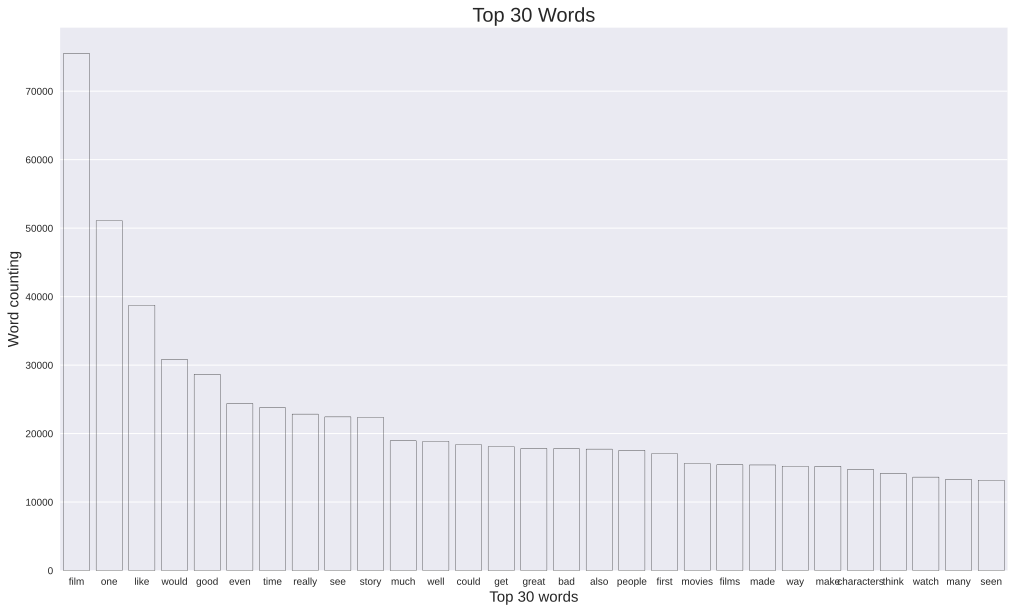

In [ ]:
draw_top_words(data=data['review'], top_size=30, title='Top')


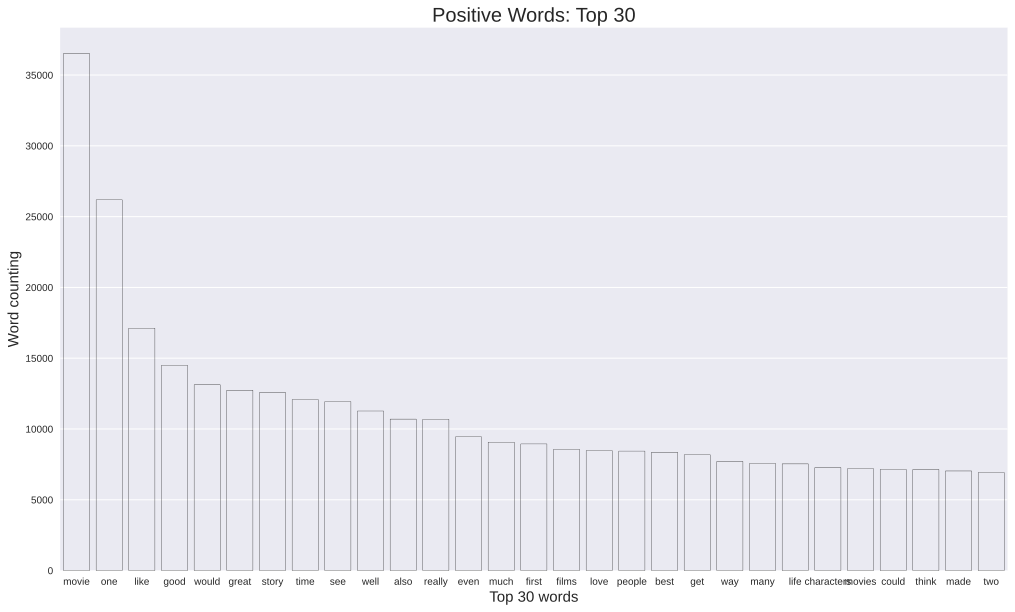

In [ ]:
draw_top_words(data=pos['review'], top_size=30, title='positive')

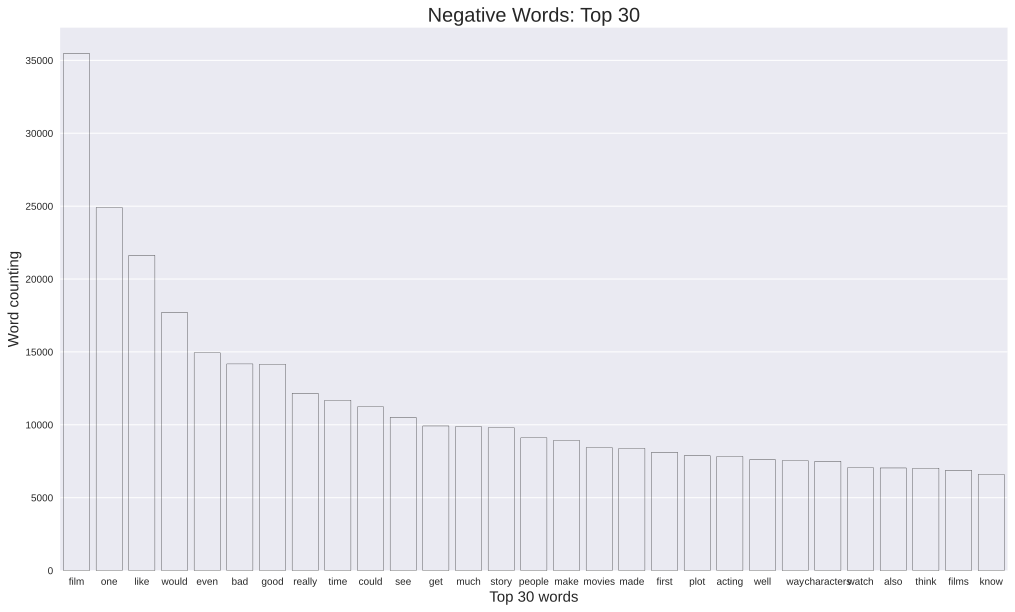

In [ ]:
draw_top_words(data=neg['review'], top_size=30, title='negative')

**Conclusion**  

* It is obvious that some words that play a big role are of little use in further training models, so it is worth deleting them.
* Words like *movie or film* are the theme which all reviews share. Thus I suppose idf(inverse document frequency) should be close to zero.

In [ ]:
COMMONWORDS = {'film', 'one', 'movie', 'like', 'would', 'time', 'see'}

def remove_common_words(text):
    """remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in COMMONWORDS])

In [ ]:
data['review'] =  data['review'].apply(lambda text: remove_common_words(text))
data.head(1)

review  \
0  reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthat get touch darker side   

  sentiment  
0  positive

Let's look at result:

In [ ]:
pos = data[data['sentiment']=='positive']
neg = data[data['sentiment']=='negative']

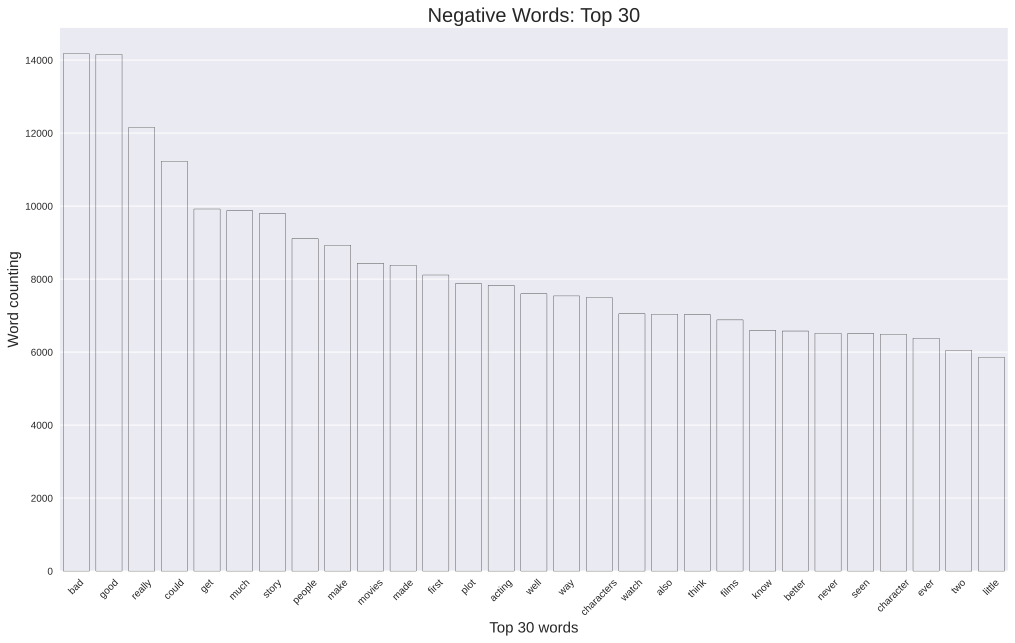

In [ ]:
draw_top_words(data=neg['review'], top_size=30, title='negative')

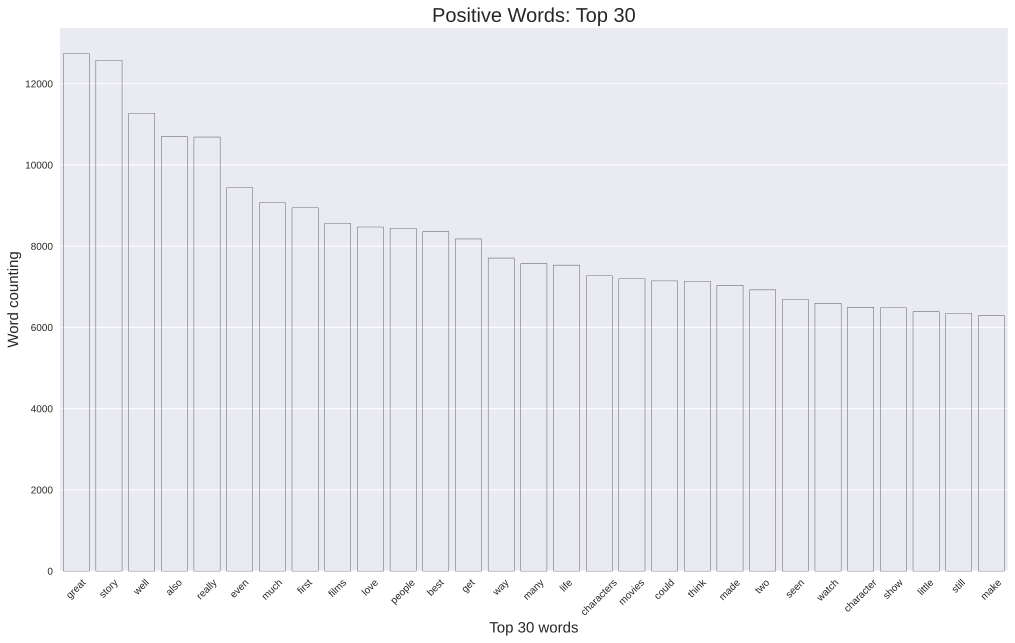

In [ ]:
draw_top_words(data=pos['review'], top_size=30, title='positive')

**Word clouds**


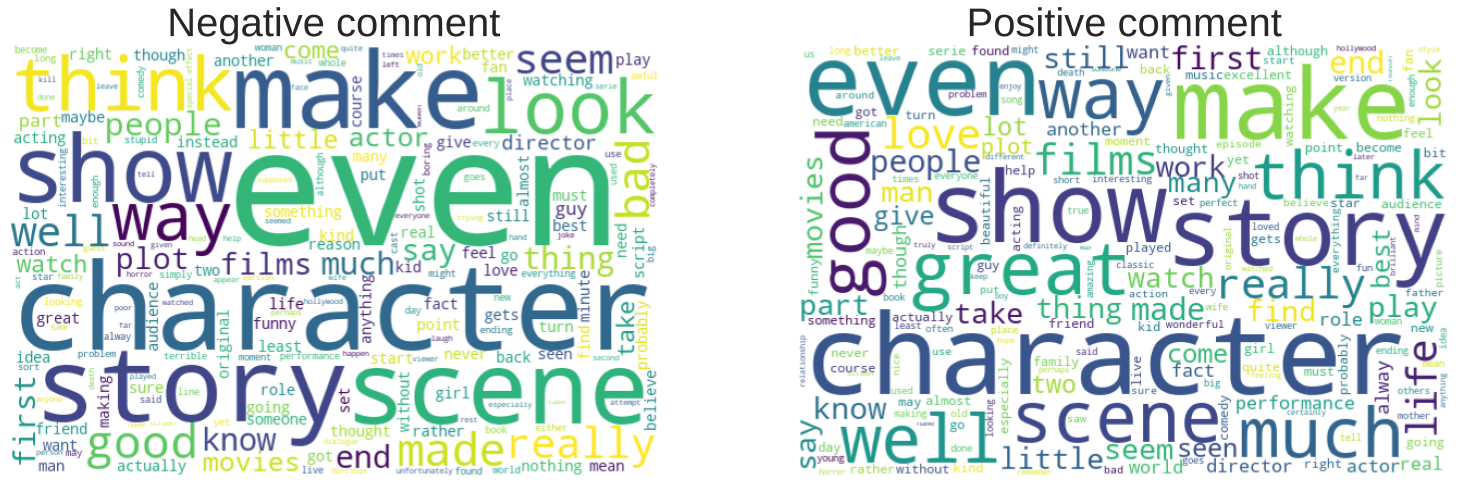

In [ ]:
draw_word_clouds(pos, neg)

**Conclusion**
* The top 30 words have changed a little for the better.
* It is noticeable that the text data is cleared, there are no tags.
* The words are different, but of course there are similarities.

The 2nd preprocessing step:

* At this stage, I wanted to remove all the written numbers from the text, since they do not play a role for the model, but the power of my computer did not allow me to do this quickly (I waited for a very long time)
* Next, it is a very good practice to correct capital errors in the text, but again the whole problem was the power of the computer and I did not wait for the code execution to finish.
* However, despite the fact that these two points were skipped, scores on the models still showed a decent result of execution, so for now you can skip these points and use other computing power in the future.

**Removal of uppercase numbers**

In [ ]:
# def remove_written_numbers(text):
#   nlp = spacy.load('en_core_web_sm')
#   doc = nlp(text)

#   tokens = [token.text for token in doc if token.pos_ != 'NUM']
#   return " ".join(tokens)

In [ ]:
# data['review'] =  data['review'].apply(lambda text: remove_written_numbers(text))
# data.head(1)

In [ ]:
# data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_drop_nums.csv',sep=',', header=True, index=True)

**Spelling Correction**  
One another important text preprocessing step is spelling correction. Typos are common in text data and we might want to correct those spelling mistakes before we do our analysis.

In this notebook, I'll use the python package *symspellpy* for this dataset spelling correction.

In [ ]:
# !pip install symspellpy

     |████████████████████████████████| 2.6 MB 8.5 MB/s 


In [ ]:
# import pkg_resources
# from symspellpy import SymSpell, Verbosity

# def spellcorrector(text):
#   sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
#   dictionary_path = pkg_resources.resource_filename(
#       "symspellpy", "frequency_dictionary_en_82_765.txt")
#   bigram_path = pkg_resources.resource_filename(
#       "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
#   # term_index is the column of the term and count_index is the
#   # column of the term frequency
#   sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
#   sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
#   # lookup suggestions for multi-word input strings (supports compound
#   # splitting & merging)
#   # max edit distance per lookup (per single word, not per whole input string)
#   suggestions = sym_spell.lookup_compound((text), max_edit_distance=2)
#   # display suggestion term, edit distance, and term frequency
#   corrected_text = ""
#   for suggestion in suggestions:
#       corrected_text =corrected_text + str(suggestion).split(",")[0]

#   return corrected_text

In [ ]:
# data['review'] = data['review'].apply(lambda text: spellcorrector(text))
# data.head(1)

In [ ]:
# data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_spelling_2stage.csv')

## **Tokenization**  

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc.

In [ ]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
data['review'] = data['review'].apply(lambda x: tokenizer.tokenize(x))
data['review'].head(1)

0    [reviewers, mentioned, watching, oz, episode, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pulls, punches, regards, drugs, sex, violence, hardcore, classic, use, word, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focuses, mainly, emerald, city, experimental, section, prison, cells, glass, fronts, face, inwards, privacy, high, agenda, city, home, manyaryans, muslims, gangstas, latinos, christians, italians, irish, moreso, scuffles, death, stares, dodgy, dealings, shady, agreements, never, far, away, say, main, appeal, show, due, fact, goes, shows, dare, forget, pretty, pictures, painted, mainstream, audiences, forget, charm, forget, romanceoz, ...]
Name: review, dtype: object

## **Normalisation (comparison of stemming and lemmatization)**

In [ ]:
data.loc[:, 'sentiment'].replace("negative", 0, inplace=True)
data.loc[:, 'sentiment'].replace("positive", 1, inplace=True)
data.head(1)

review  \
0  [reviewers, mentioned, watching, oz, episode, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pulls, punches, regards, drugs, sex, violence, hardcore, classic, use, word, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focuses, mainly, emerald, city, experimental, section, prison, cells, glass, fronts, face, inwards, privacy, high, agenda, city, home, manyaryans, muslims, gangstas, latinos, christians, italians, irish, moreso, scuffles, death, stares, dodgy, dealings, shady, agreements, never, far, away, say, main, appeal, show, due, fact, goes, shows, dare, forget, pretty, pictures, painted, mainstream, audiences, forget, charm, forget, romanceoz, ...]   

   sentiment  
0          1

In [ ]:
stem_data = data.copy(deep=True)
lem_data = data.copy(deep=True)

# **I variant (Stemming)**

## **Stemming**  

Stemming is a process of reducing words to their word stem, base or root form (for example, books — book, looked — look). The main algorithms used for stemming is Porter stemming algorithm.

In [ ]:
stem_data['review'] = stem_data['review'].apply(lambda text: stem_words(text))
stem_data.head(1)

review  \
0  review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingthat get touch darker side   

   sentiment  
0          1

In [ ]:
stem_data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_stemm.csv',sep=',', header=True, index=True)

In [ ]:
drive.mount("/content/drive")
stem_data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_stemm.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49577 entries, 0 to 49576
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49577 non-null  int64 
 1   review      49577 non-null  object
 2   sentiment   49577 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
stem_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_add = stem_data.copy(deep=True)  # for additional part at the end of notebook

## **Split**

In [ ]:
(trainData, 
 testData, 
 train_label, 
 test_label) = train_test_split(stem_data.drop('sentiment',
                                            axis=1),
                                            stem_data['sentiment'],
                                            stratify=stem_data['sentiment'],
                                            test_size=0.2,
                                            random_state=42)

print('Size of train set:', trainData.shape)
print('Size of test set:', testData.shape)

print('\nClass distribution on train:',
      train_label.value_counts(normalize=True),
      '\nClass distribution on test:', 
      test_label.value_counts(normalize=True),
      sep='\n')

Size of train set: (39661, 1)
Size of test set: (9916, 1)

Class distribution on train:
1    0.501878
0    0.498122
Name: sentiment, dtype: float64

Class distribution on test:
1    0.501916
0    0.498084
Name: sentiment, dtype: float64


## **TFIDF**
**Transforming tokens to a vector**  

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. 

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short.

In [ ]:
tfidf = TfidfVectorizer(min_df=3, 
                        max_features=None,
                        analyzer='word',
                        token_pattern=r'\w{1,}',
                        ngram_range=(1, 3),
                        use_idf=1,
                        smooth_idf=1,
                        sublinear_tf=1)

train_tfidf = tfidf.fit_transform(trainData['review'])
test_tfidf = tfidf.transform(testData["review"])

## **Models**

### **Logistic Regression**

* I use this model just to test data quality.

**Selection of optimal hyperparameters**

In [3]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 5, 'tol': 0.1}

**Now we will train the model with the selected parameters**

In [ ]:
lgr = LogisticRegression(C=5,
                         tol=0.1)

In [ ]:
lgr.fit(train_tfidf, train_label)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.1, verbose=0,
                   warm_start=False)

In [ ]:
%%time
pred = lgr.predict(test_tfidf)

CPU times: user 12.3 ms, sys: 16.3 ms, total: 28.6 ms
Wall time: 18.2 ms


**Words importance**

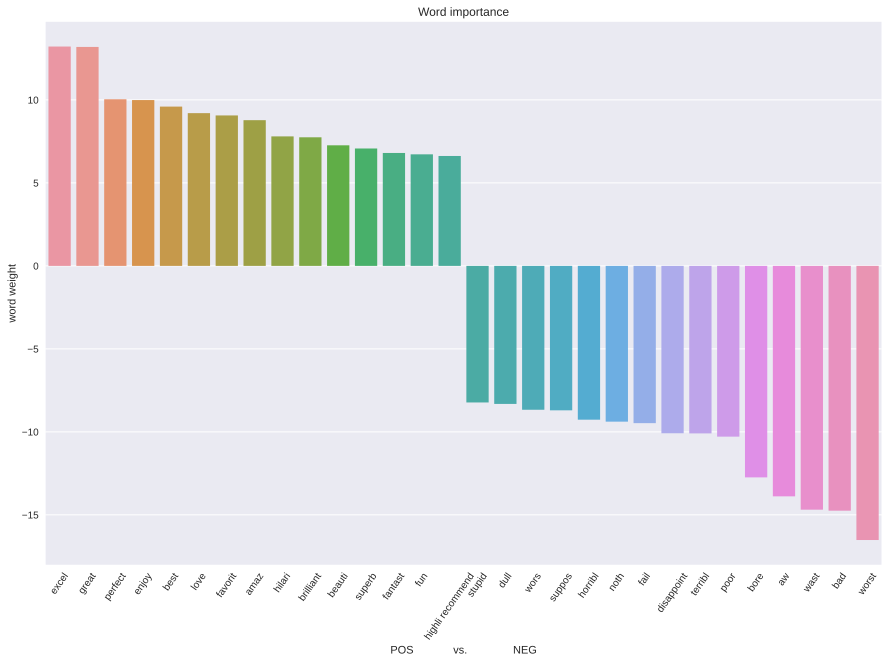

In [ ]:
get_word_importance(lgr ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that the logistic regression copes well with the task.
* In *positive* comments, the words **excel, great, perfect** play more weight.
* In *negative* comments, the words words **worst, bad, wasted** play a greater role.

**Quality assessment**

In [ ]:
!ls

%cd /content/drive/My Drive/DA/HW5/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

drive  sample_data
/content/drive/My Drive/DA/HW5


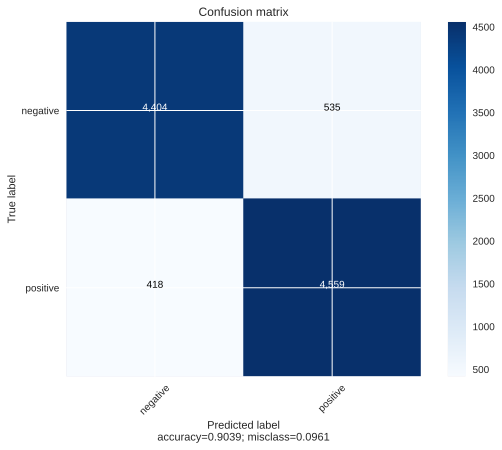

Accuracy: 0.90389 
Balanced accuracy: 0.90385 
Multiclass f1-score: 
    micro: 0.90389 
    macro: 0.90387 
    weighted: 0.90387


Classification report:

              precision    recall  f1-score   support

           0    0.91331   0.89168   0.90237      4939
           1    0.89497   0.91601   0.90537      4977

    accuracy                        0.90389      9916
   macro avg    0.90414   0.90385   0.90387      9916
weighted avg    0.90411   0.90389   0.90387      9916



In [ ]:
calc_metrics(test_label, pred)

**ROC AUC**

ROC AUC: 
    macro: 0.9665 
    weighted: 0.9665


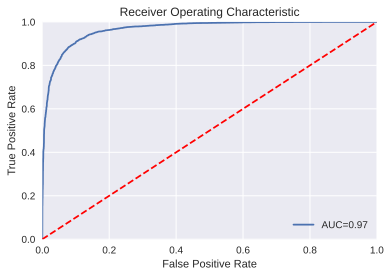

In [ ]:
count_roc_auc(lgr, test_tfidf, test_label, num_classes, classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9522597635296728


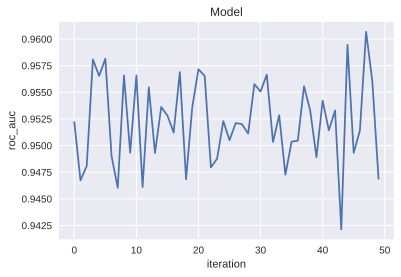

In [ ]:
calc_rocauc_cross_val(lgr, test_tfidf, test_label)

**Conclusion**

* Simple accuracy gives an excellent result-0.9, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.9, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.

## **Compare performance of models:**

## **SGDClassifier**

### **Simple model**

In [ ]:
sgd_model = SGDClassifier()
sgd_model.fit(train_tfidf, train_label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
preds = sgd_model.predict(test_tfidf)

**Words importance**

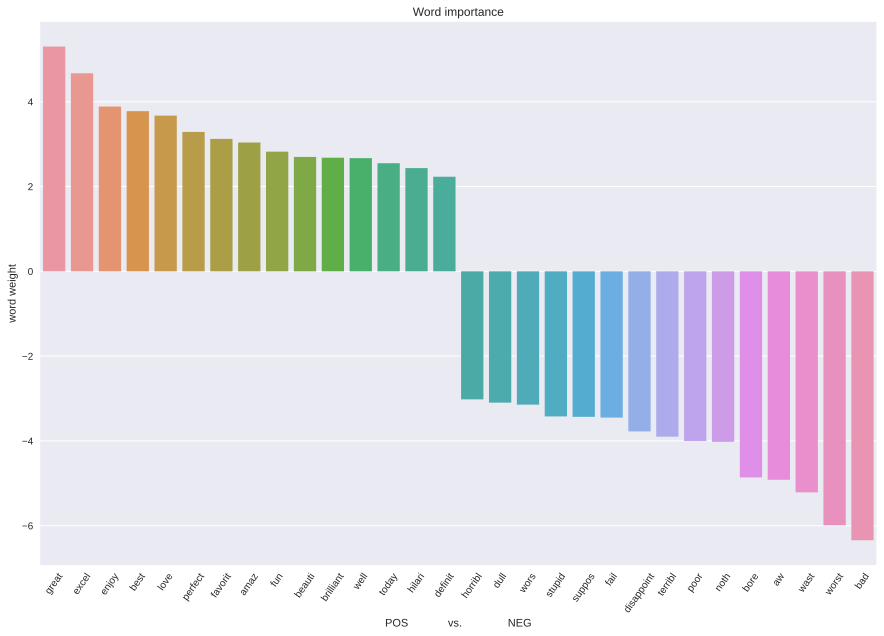

In [ ]:
get_word_importance(sgd_model ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that the SGDClassifier copes well with the task.
* In *positive* comments, the words **great, excel, enjoy** play more weight.
* In *negative* comments, the words words **bad, worst, wast** play a greater role.


**Quality assessment**

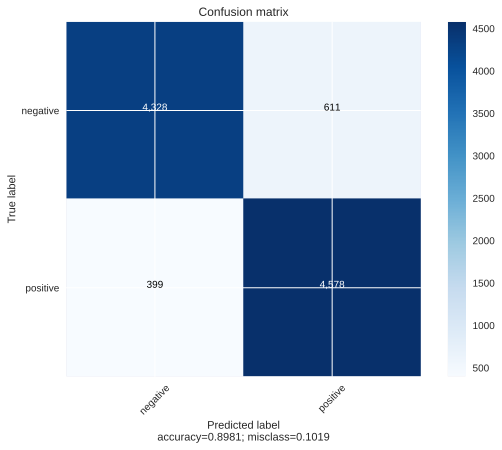

Accuracy: 0.89814 
Balanced accuracy: 0.89806 
Multiclass f1-score: 
    micro: 0.89814 
    macro: 0.89808 
    weighted: 0.89809


Classification report:

              precision    recall  f1-score   support

           0    0.91559   0.87629   0.89551      4939
           1    0.88225   0.91983   0.90065      4977

    accuracy                        0.89814      9916
   macro avg    0.89892   0.89806   0.89808      9916
weighted avg    0.89886   0.89814   0.89809      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96301 
    weighted: 0.96301


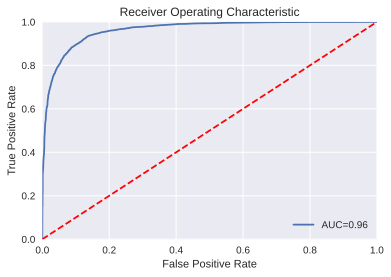

In [ ]:
count_rocauc_classif(sgd_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9524102909430493


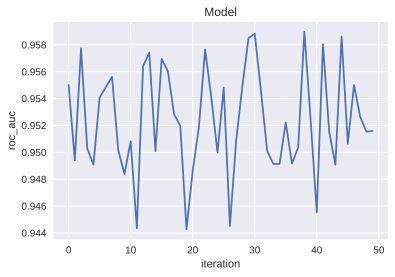

In [ ]:
calc_rocauc_cross_val(sgd_model, test_tfidf, test_label)

**Conclusion**

* The values of the metrics decreased slightly compared to the logistic regression.
* Simple accuracy gives an excellent result-0.898, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.898, which is good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close/equal to 0,9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.96 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.


### **Hyperparameters tuning**

In [ ]:
params = {
    'penalty':  ['l2', 'l1', 'elasticnet'],
    'alpha':  [0.0001, 0.005, 0.05, 0.1, 1],
     'tol':  [0.05, 0.1, 1, 10],
     'verbose': [0, 1, 5, 10],
     'n_jobs': [-1, 1 ,5]
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
sgd_model = SGDClassifier()
gd = GridSearchCV(sgd_model,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=-1)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.005, 0.05, 0.1, 1],
                         'n_jobs': [-1, 1, 5],
                    

In [ ]:
gd.best_params_

{'alpha': 0.0001, 'n_jobs': 5, 'penalty': 'l2', 'tol': 10, 'verbose': 0}

**Now we will train the model with the selected parameters**

In [ ]:
sgd_model = SGDClassifier(penalty='l2',
                          alpha=0.0001,
                          tol=10,
                          verbose=0,
                          n_jobs=5)

In [ ]:
sgd_model.fit(train_tfidf, train_label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=5, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=10,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
%%time
preds = sgd_model.predict(test_tfidf)

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 16.2 ms


**Words importance**

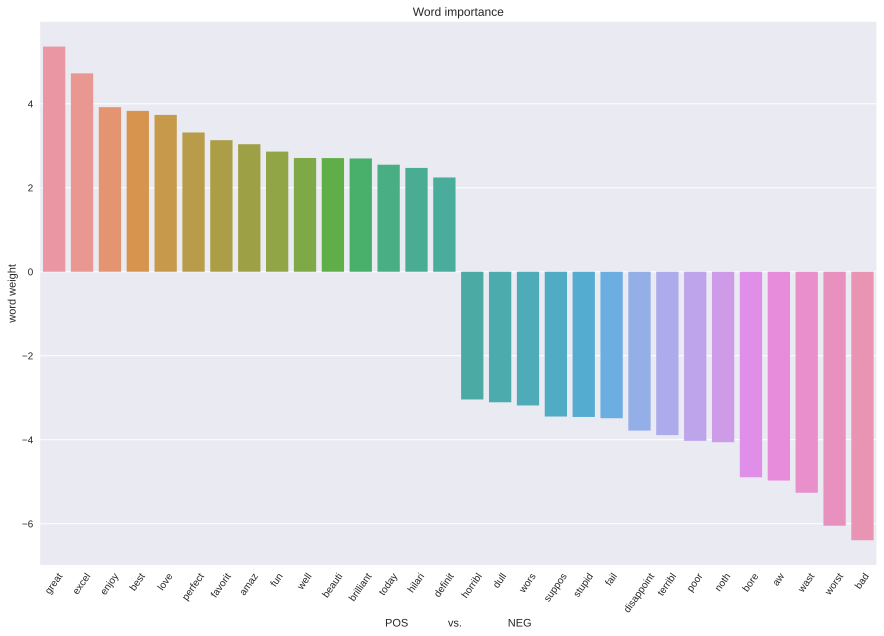

In [ ]:
get_word_importance(sgd_model, tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that the SGDClassifier copes well with the task.
* In *positive* comments, the words **excel, great, perfect** play more weight.
* In *negative* comments, the words words **worst, bad, wasted** play a greater role.


**Quality assessment**

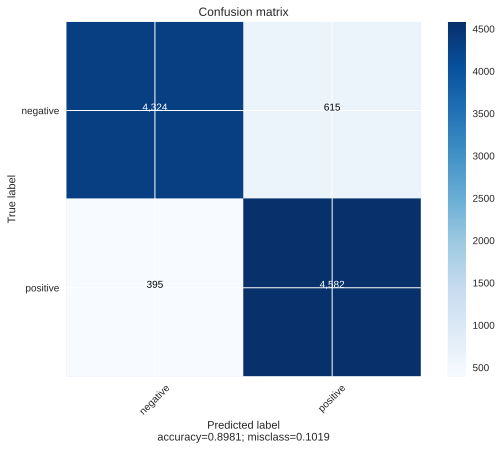

Accuracy: 0.89814 
Balanced accuracy: 0.89806 
Multiclass f1-score: 
    micro: 0.89814 
    macro: 0.89808 
    weighted: 0.89809


Classification report:

              precision    recall  f1-score   support

           0    0.91630   0.87548   0.89542      4939
           1    0.88166   0.92063   0.90073      4977

    accuracy                        0.89814      9916
   macro avg    0.89898   0.89806   0.89808      9916
weighted avg    0.89891   0.89814   0.89809      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96303 
    weighted: 0.96303


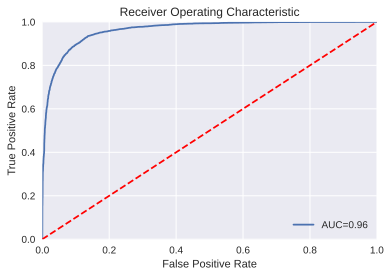

In [ ]:
count_rocauc_classif(sgd_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9527351194939097


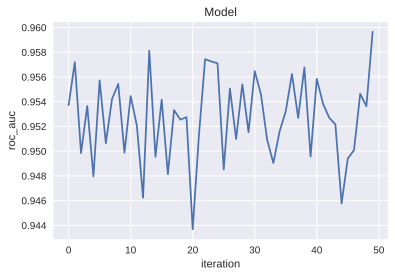

In [ ]:
calc_rocauc_cross_val(sgd_model, test_tfidf, test_label)

**Conclusion**

* After tuning the hyperparameters, the values changed slightly, increased by thousandths.
* The values of the metrics decreased slightly compared to the logistic regression.
* Simple accuracy gives an excellent result-0.9, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.9, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.


### **SVM**

### **Simple model**

In [ ]:
svc_model = LinearSVC()
svc_model.fit(train_tfidf, train_label)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
preds = svc_model.predict(test_tfidf)

**Words importance**

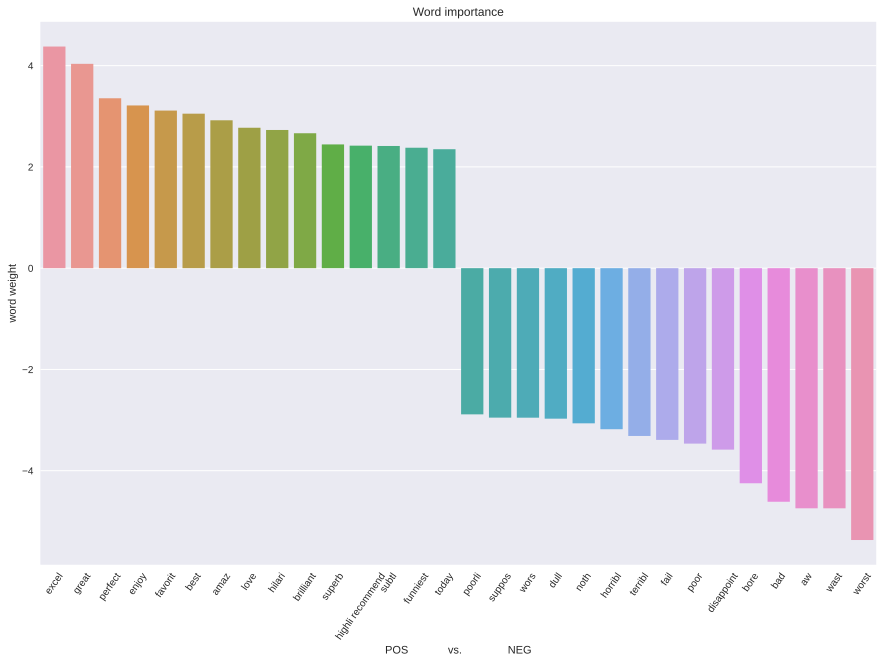

In [ ]:
get_word_importance(svc_model ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that the logistic regression copes well with the task.
* In *positive* comments, the words **excel, great, perfect** play more weight.
* In *negative* comments, the words words **worst, wast, aw, bad** play a greater role. (neg. words have more weights)


**Quality assessment**

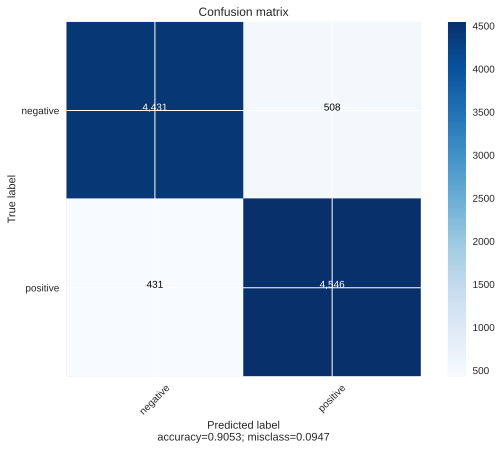

Accuracy: 0.9053 
Balanced accuracy: 0.90527 
Multiclass f1-score: 
    micro: 0.9053 
    macro: 0.90529 
    weighted: 0.9053


Classification report:

              precision    recall  f1-score   support

           0    0.91135   0.89715   0.90419      4939
           1    0.89949   0.91340   0.90639      4977

    accuracy                        0.90530      9916
   macro avg    0.90542   0.90527   0.90529      9916
weighted avg    0.90540   0.90530   0.90530      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96739 
    weighted: 0.96739


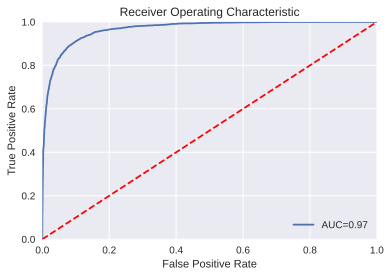

In [ ]:
count_rocauc_classif(svc_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9530886388553115


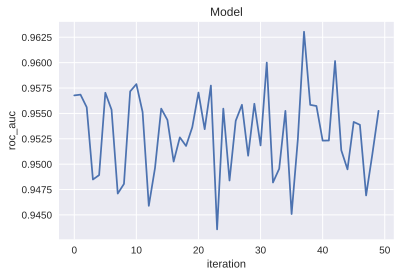

In [ ]:
calc_rocauc_cross_val(svc_model, test_tfidf, test_label)

**Conclusion**

* The values of the metrics increased slightly compared to the SGDClassifier.
* Simple accuracy gives an excellent result-0.9, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.9, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1 (0.9). This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.



### **Hyperparameters tuning**

In [ ]:
params = {
    'penalty' : ['l1', 'l2'],
    'tol': [1e-3, 1e-4],
    'C': [0.1, 1, 10, 50,  100]
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
svcm = LinearSVC()
gd = GridSearchCV(svcm,
                  params,
                  cv=rskf, 
                  scoring='f1',
                  n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 50, 100], 'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 1, 'penalty': 'l2', 'tol': 0.001}

**Now we will train the model with the selected parameters**

In [ ]:
svc_model = LinearSVC(C=1, penalty='l2', tol=0.001)

In [ ]:
svc_model.fit(train_tfidf, train_label)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

In [ ]:
%%time
preds = svc_model.predict(test_tfidf)

CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 15.9 ms


**Words importance**

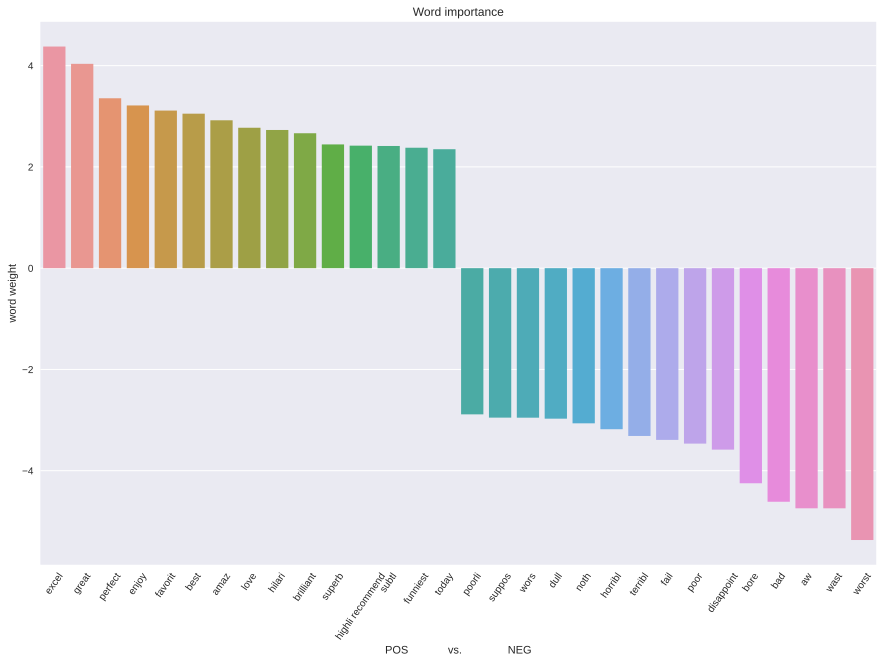

In [ ]:
get_word_importance(svc_model ,tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that SVM copes well with the task.
* In *positive* comments, the words **excel, great, perfect** play more weight.
* In *negative* comments, the words words **worst, wast, aw, bad** play a greater role.


**Quality assessment**

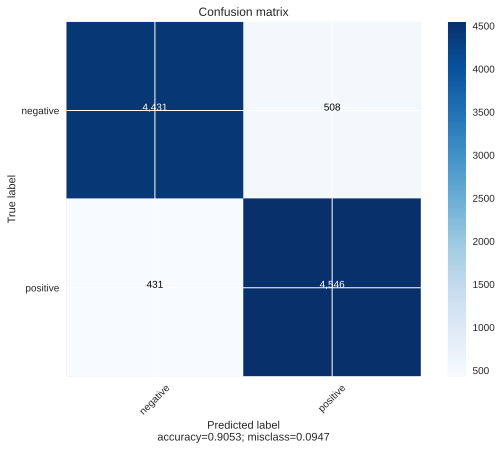

Accuracy: 0.9053 
Balanced accuracy: 0.90527 
Multiclass f1-score: 
    micro: 0.9053 
    macro: 0.90529 
    weighted: 0.9053


Classification report:

              precision    recall  f1-score   support

           0    0.91135   0.89715   0.90419      4939
           1    0.89949   0.91340   0.90639      4977

    accuracy                        0.90530      9916
   macro avg    0.90542   0.90527   0.90529      9916
weighted avg    0.90540   0.90530   0.90530      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96739 
    weighted: 0.96739


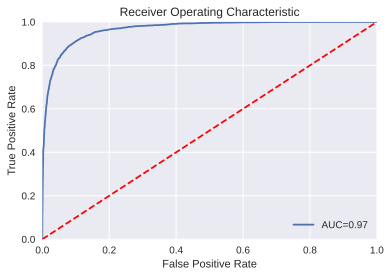

In [ ]:
count_rocauc_classif(svc_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9532264393639431


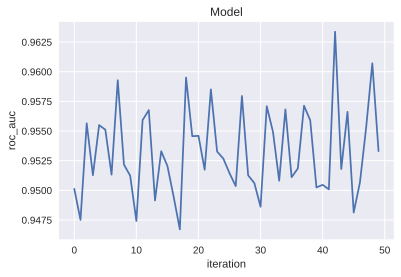

In [ ]:
calc_rocauc_cross_val(svc_model, test_tfidf, test_label)


**Conclusion**

*	After tuning the hyperparameters, the values don't change.
*	The values of the metrics decreased slightly compared to the SGDClassifier.
* Simple accuracy gives an excellent result-0.9, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.9, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.


## **Naive Bayes**

**MultinomialNB** implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

### **Simple model**

In [ ]:
mnb_model = MultinomialNB()
mnb_model.fit(train_tfidf, train_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
preds = mnb_model.predict(test_tfidf)

**Words importance**

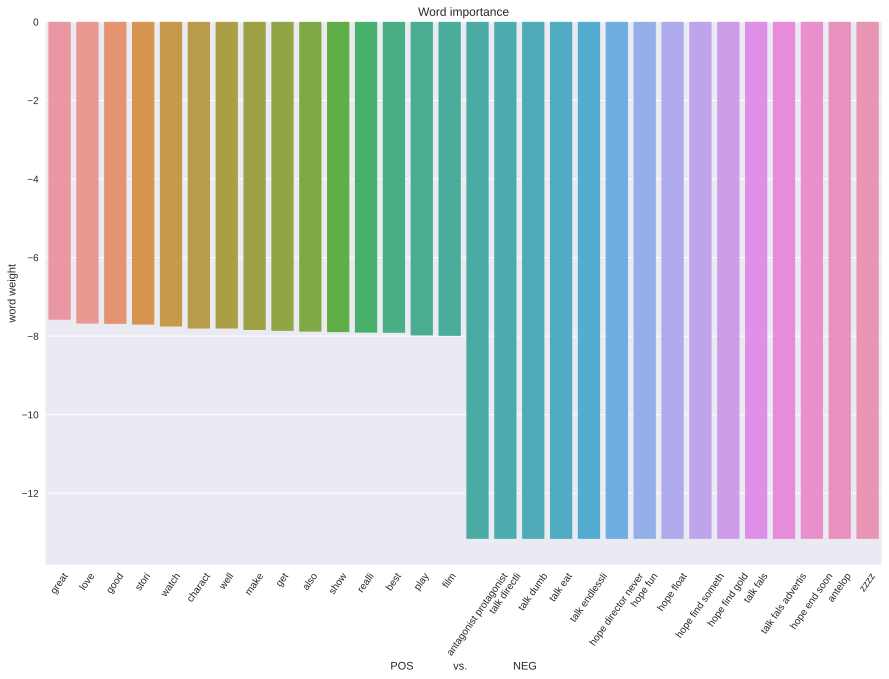

In [ ]:
get_word_importance(mnb_model ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that Naive Bayes gave more weight to strange and unusual words and phrases in negative comments.
* In *positive* comments, the words **great, love, good** play more weight.
* In *negative* comments, the words words **zzzz, antelop, hope and soon** play a greater role.


**Quality assessment**

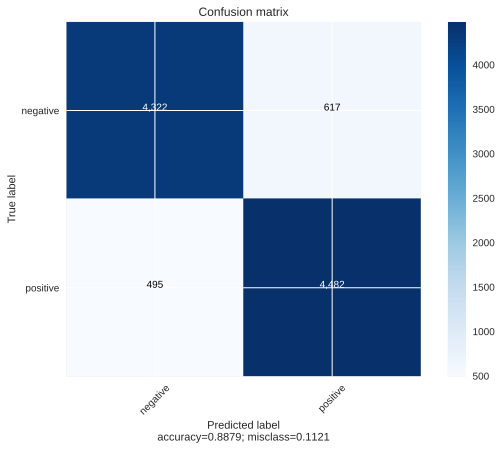

Accuracy: 0.88786 
Balanced accuracy: 0.88781 
Multiclass f1-score: 
    micro: 0.88786 
    macro: 0.88783 
    weighted: 0.88784


Classification report:

              precision    recall  f1-score   support

           0    0.89724   0.87508   0.88602      4939
           1    0.87900   0.90054   0.88964      4977

    accuracy                        0.88786      9916
   macro avg    0.88812   0.88781   0.88783      9916
weighted avg    0.88808   0.88786   0.88784      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.95452 
    weighted: 0.95452


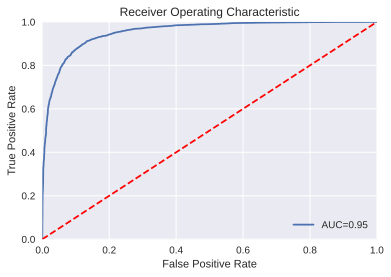

In [ ]:
count_roc_auc(mnb_model, test_tfidf, test_label, num_classes,classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.941825390449087


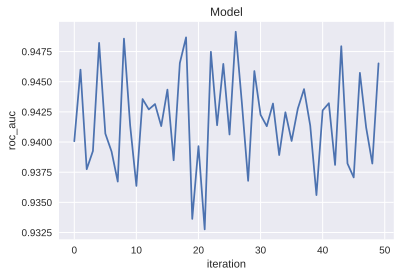

In [ ]:
calc_rocauc_cross_val(mnb_model, test_tfidf, test_label)

**Conclusion**

* In simple NB model the values of the metrics highly decreased compared to the other models.
* Simple accuracy gives an excellent result-0.89, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.89, which is not very high in comparison to other models.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.95 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.94.


### **Hyperparameters tuning**

In [ ]:
params = {
    'alpha':  [0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'fit_prior':  [True, False],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
mnb = MultinomialNB()
gd = GridSearchCV(mnb,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': [0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'alpha': 0.5, 'fit_prior': True}

**Now we will train the model with the selected parameters**

In [ ]:
mnb_model = MultinomialNB(alpha=0.5,
                         fit_prior=True)

In [ ]:
mnb_model.fit(train_tfidf, train_label)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [ ]:
%%time
preds = mnb_model.predict(test_tfidf)

CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 30.3 ms


**Words importance**

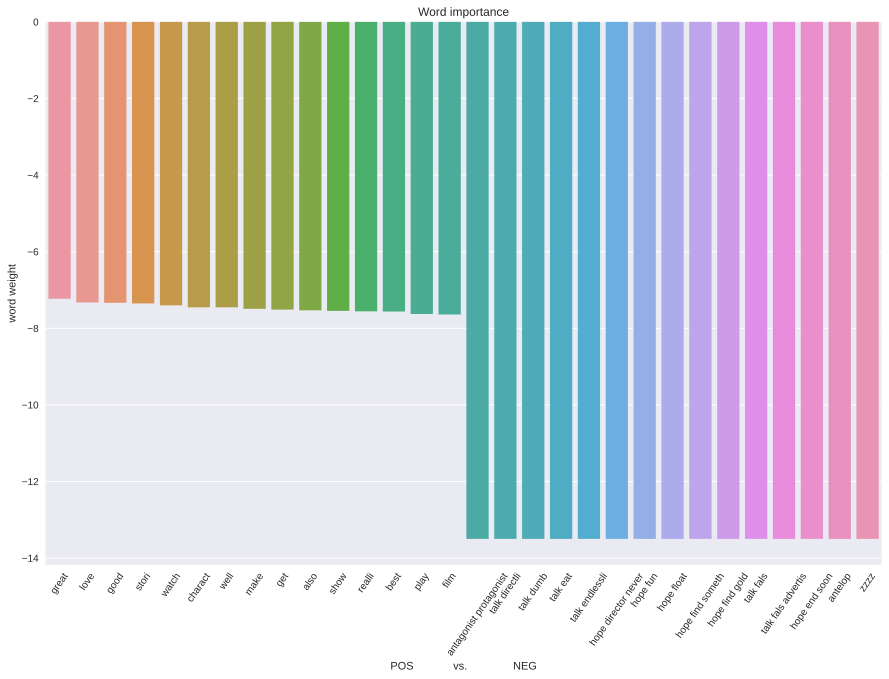

In [ ]:
get_word_importance(mnb_model ,tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that Naive Bayes gave more weight to strange and unusual words and phrases in negative comments.
* In *positive* comments, the words **great, love, good** play more weight.
* In *negative* comments, the words words **zzzz, antelop, hope and soon** play a greater role.


**Quality assessment**

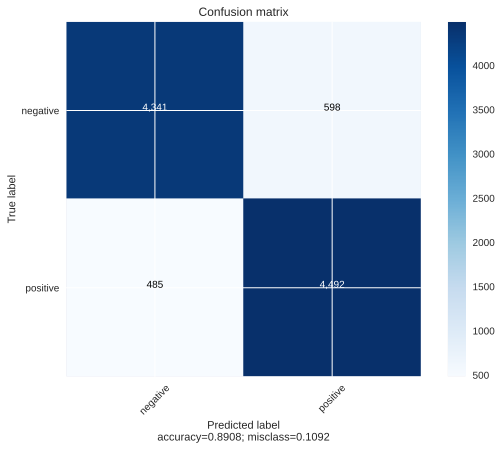

Accuracy: 0.89078 
Balanced accuracy: 0.89074 
Multiclass f1-score: 
    micro: 0.89078 
    macro: 0.89076 
    weighted: 0.89076


Classification report:

              precision    recall  f1-score   support

           0    0.89950   0.87892   0.88909      4939
           1    0.88251   0.90255   0.89242      4977

    accuracy                        0.89078      9916
   macro avg    0.89101   0.89074   0.89076      9916
weighted avg    0.89098   0.89078   0.89076      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.95548 
    weighted: 0.95548


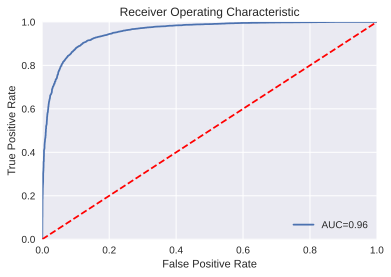

In [ ]:
count_roc_auc(mnb_model, test_tfidf, test_label, num_classes,classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9417770762401412


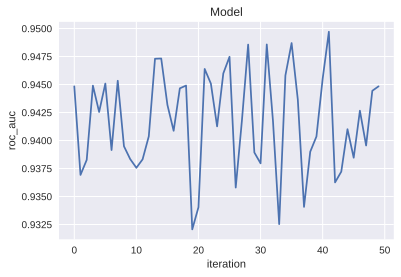

In [ ]:
calc_rocauc_cross_val(mnb_model, test_tfidf, test_label)

**Conclusion**

*	After tuning the hyperparameters, the values changed slightly, but increased.
*	The values of the metrics decreased slightly compared to all other models.
* Simple accuracy gives an excellent result-0.89, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.89, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.96 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.94.


# **II variant (Lemmatization)**

## **Lemmatization**  

The aim of lemmatization, like stemming, is to reduce inflectional forms to a common base form. As opposed to stemming, lemmatization does not simply chop off inflections. Instead it uses lexical knowledge bases to get the correct base forms of words. # Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language. As a result, this one is generally slower than stemming process. So depending on the speed requirement, we can choose to use either stemming or lemmatization.

In [ ]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


In [ ]:
lem_data['review'] = lem_data['review'].apply(lambda text: lemmatize_words(text))
lem_data.head(1)

review  \
0  reviewer mention watch oz episode hook right exactly happen first thing strike oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda city home manyaryans muslims gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away say main appeal show due fact go show dare forget pretty picture paint mainstream audience forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watch developed taste oz get accustomed high level graphic violence violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comfortable uncomfortable viewingthat get touch darker side   

   sentiment  
0          1

In [ ]:
lem_data.to_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_lemmat.csv',sep=',', header=True, index=True)

In [ ]:
drive.mount("/content/drive")
lem_data = pd.read_csv('/content/drive/My Drive/DA/HW6/updatedMovieDataset_lemmat.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49577 entries, 0 to 49576
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49577 non-null  int64 
 1   review      49577 non-null  object
 2   sentiment   49577 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
lem_data.drop('Unnamed: 0', axis=1, inplace=True)

## **Split**

In [ ]:
(trainData, 
 testData, 
 train_label, 
 test_label) = train_test_split(lem_data.drop('sentiment',
                                            axis=1),
                                            lem_data['sentiment'],
                                            stratify=lem_data['sentiment'],
                                            test_size=0.2,
                                            random_state=42)

print('Size of train set:', trainData.shape)
print('Size of test set:', testData.shape)

print('\nClass distribution on train:',
      train_label.value_counts(normalize=True),
      '\nClass distribution on test:', 
      test_label.value_counts(normalize=True),
      sep='\n')

Size of train set: (39661, 1)
Size of test set: (9916, 1)

Class distribution on train:
1    0.501878
0    0.498122
Name: sentiment, dtype: float64

Class distribution on test:
1    0.501916
0    0.498084
Name: sentiment, dtype: float64


## **TFIDF**
**Transforming tokens to a vector**  

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. 

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short.

In [ ]:
tfidf = TfidfVectorizer(min_df=3, 
                        max_features=None,
                        analyzer='word',
                        token_pattern=r'\w{1,}',
                        ngram_range=(1, 3),
                        use_idf=1,
                        smooth_idf=1,
                        sublinear_tf=1)

train_tfidf = tfidf.fit_transform(trainData['review'])
test_tfidf = tfidf.transform(testData["review"])

### **Logistic Regression**  
* I use this model just to test data quality.

**Selection of optimal hyperparameters**

In [ ]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 5, 'tol': 0.5}

**Now we will train the model with the selected parameters**

In [ ]:
lgr = LogisticRegression(C=5, tol=0.5)

In [ ]:
%%time
lgr.fit(train_tfidf, train_label)

CPU times: user 8.91 s, sys: 7.34 s, total: 16.3 s
Wall time: 8.66 s


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.5, verbose=0,
                   warm_start=False)

In [ ]:
pred = lgr.predict(test_tfidf)

**Words importance**

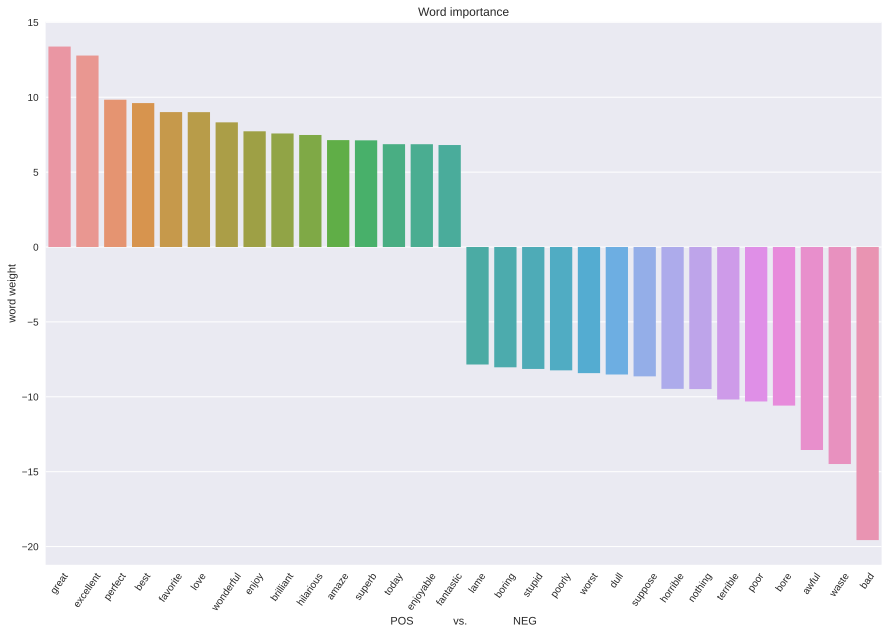

In [ ]:
get_word_importance(lgr ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that the logistic regression copes well with the task.
* In *positive* comments, the words **great, excellent, perfect** play more weight.
* In *negative* comments, the words words **bad, waste, awful** play a greater role.


**Quality assessment**

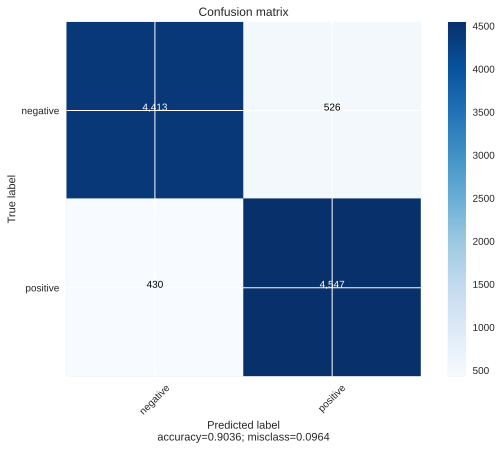

Accuracy: 0.90359 
Balanced accuracy: 0.90355 
Multiclass f1-score: 
    micro: 0.90359 
    macro: 0.90357 
    weighted: 0.90358


Classification report:

              precision    recall  f1-score   support

           0    0.91121   0.89350   0.90227      4939
           1    0.89631   0.91360   0.90488      4977

    accuracy                        0.90359      9916
   macro avg    0.90376   0.90355   0.90357      9916
weighted avg    0.90373   0.90359   0.90358      9916



In [ ]:
calc_metrics(test_label, pred)

**ROC AUC**

ROC AUC: 
    macro: 0.96633 
    weighted: 0.96633


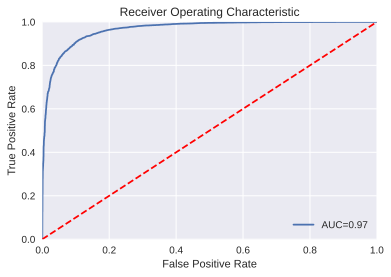

In [ ]:
count_roc_auc(lgr, test_tfidf, test_label, num_classes, classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.95177418244508


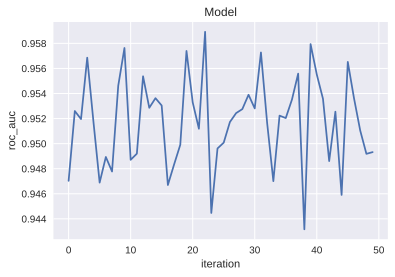

In [ ]:
calc_rocauc_cross_val(lgr, test_tfidf, test_label)

**Conclusion**

* Simple accuracy gives an excellent result-0.903, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.903, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1 (0.904). This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.


## **Compare performance of models:**

## **SGDClassifier**


### **Simple model**

In [ ]:
sgd_model = SGDClassifier()
sgd_model.fit(train_tfidf, train_label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
preds = sgd_model.predict(test_tfidf)

**Words importance**

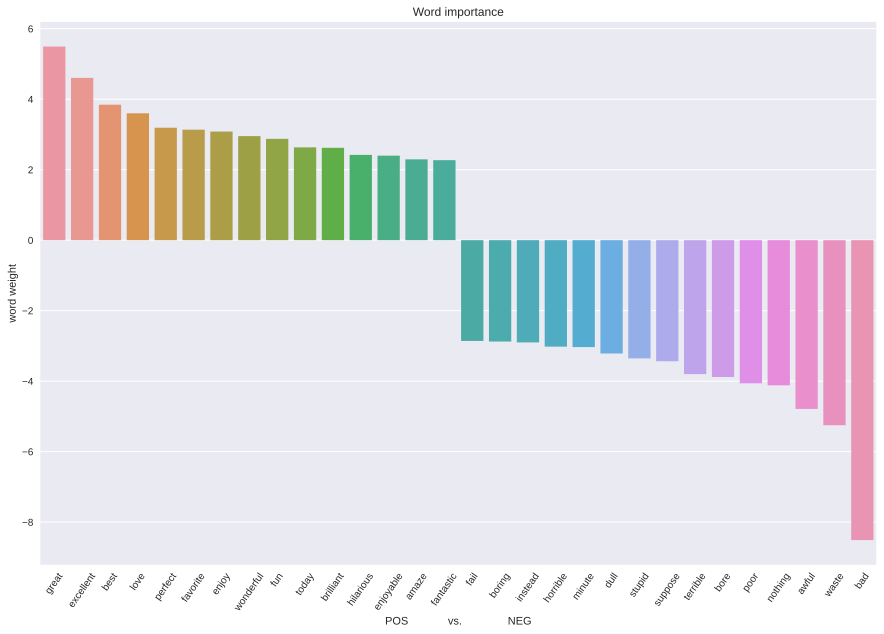

In [ ]:
get_word_importance(sgd_model ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that the SGDClassifier copes well with the task.
* In *positive* comments, the words **great, excellent, best** play more weight.
* In *negative* comments, the words words **bad, waste, awful** play a greater role.


**Quality assessment**

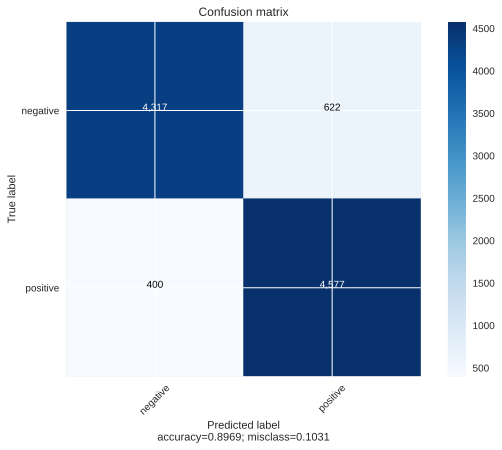

Accuracy: 0.89693 
Balanced accuracy: 0.89685 
Multiclass f1-score: 
    micro: 0.89693 
    macro: 0.89686 
    weighted: 0.89687


Classification report:

              precision    recall  f1-score   support

           0    0.91520   0.87406   0.89416      4939
           1    0.88036   0.91963   0.89957      4977

    accuracy                        0.89693      9916
   macro avg    0.89778   0.89685   0.89686      9916
weighted avg    0.89771   0.89693   0.89687      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96292 
    weighted: 0.96292


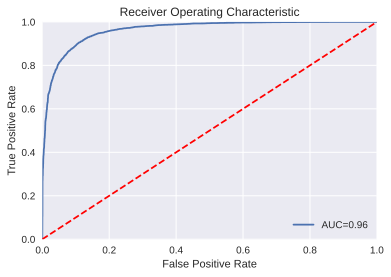

In [ ]:
count_rocauc_classif(sgd_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9515890966320214


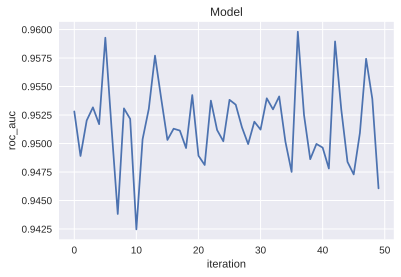

In [ ]:
calc_rocauc_cross_val(sgd_model, test_tfidf, test_label)

**Conclusion**

* The values of the metrics decreased slightly compared to the logistic regression.
* Simple accuracy gives an excellent result-0.896, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.896, which is good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.96 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.


### **Hyperparameters tuning**

In [ ]:
params = {
    'penalty':  ['l2', 'l1', 'elasticnet'],
    'alpha':  [0.0001, 0.005, 0.05, 0.1, 1],
     'tol':  [0.05, 0.1, 1, 10],
     'verbose': [0, 1, 5, 10],
     'n_jobs': [-1, 1 ,5]
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
sgd_model = SGDClassifier()
gd = GridSearchCV(sgd_model,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=-1)

In [ ]:
gd.fit(train_tfidf, train_label)

-- Epoch 1
Norm: 56.78, NNZs: 284756, Bias: 0.113512, T: 39661, Avg. loss: 0.354070
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 54.47, NNZs: 290859, Bias: 0.085203, T: 79322, Avg. loss: 0.274984
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 53.97, NNZs: 292048, Bias: 0.099781, T: 118983, Avg. loss: 0.261998
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 53.75, NNZs: 292438, Bias: 0.108038, T: 158644, Avg. loss: 0.255959
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 53.76, NNZs: 292648, Bias: 0.106475, T: 198305, Avg. loss: 0.251923
Total training time: 0.36 seconds.
-- Epoch 6
Norm: 53.69, NNZs: 292725, Bias: 0.097666, T: 237966, Avg. loss: 0.249418
Total training time: 0.43 seconds.
Convergence after 6 epochs took 0.43 seconds


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.005, 0.05, 0.1, 1],
                         'n_jobs': [-1, 1, 5],
                    

In [ ]:
gd.best_params_

{'alpha': 0.0001, 'n_jobs': 5, 'penalty': 'l2', 'tol': 1, 'verbose': 5}

**Now we will train the model with the selected parameters**

In [ ]:
sgd_model = SGDClassifier(penalty='l2',
                          alpha=0.0001,
                          tol=1,
                          verbose=5,
                          n_jobs=5)

In [ ]:
%%time
sgd_model.fit(train_tfidf, train_label)

-- Epoch 1
Norm: 56.85, NNZs: 284768, Bias: 0.098073, T: 39661, Avg. loss: 0.354322
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 54.46, NNZs: 290844, Bias: 0.110464, T: 79322, Avg. loss: 0.275152
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 54.05, NNZs: 291944, Bias: 0.103074, T: 118983, Avg. loss: 0.261926
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 53.80, NNZs: 292394, Bias: 0.102275, T: 158644, Avg. loss: 0.255251
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 53.73, NNZs: 292588, Bias: 0.093069, T: 198305, Avg. loss: 0.251933
Total training time: 0.37 seconds.
-- Epoch 6
Norm: 53.67, NNZs: 292715, Bias: 0.103152, T: 237966, Avg. loss: 0.249407
Total training time: 0.44 seconds.
Convergence after 6 epochs took 0.44 seconds
CPU times: user 499 ms, sys: 98.9 ms, total: 597 ms
Wall time: 474 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=5, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=1,
              validation_fraction=0.1, verbose=5, warm_start=False)

In [ ]:
preds = sgd_model.predict(test_tfidf)

**Words importance**

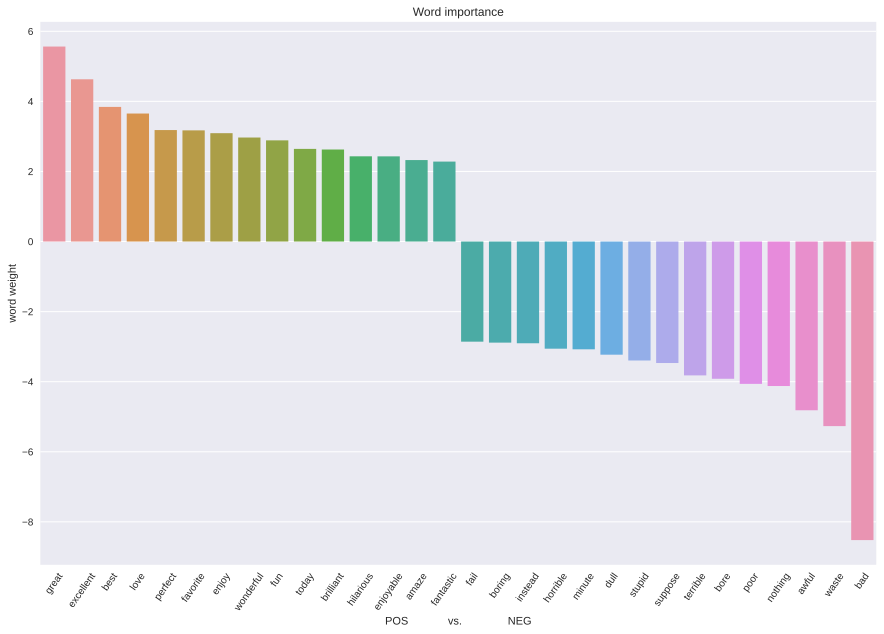

In [ ]:
get_word_importance(sgd_model, tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that the SGDClassifier copes well with the task.
* In *positive* comments, the words **great, excellent, best** play more weight.
* In *negative* comments, the words words **bad, waste, awful** play a greater role.


**Quality assessment**

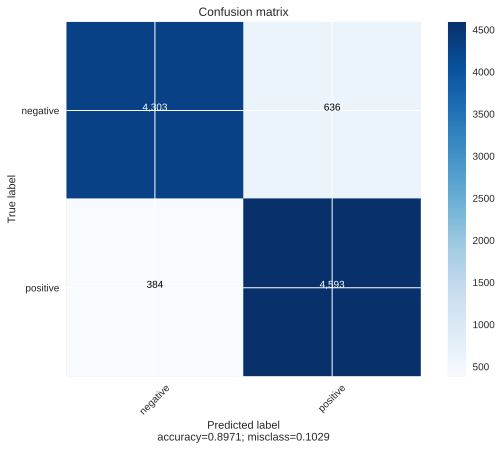

Accuracy: 0.89714 
Balanced accuracy: 0.89704 
Multiclass f1-score: 
    micro: 0.89714 
    macro: 0.89705 
    weighted: 0.89706


Classification report:

              precision    recall  f1-score   support

           0    0.91807   0.87123   0.89404      4939
           1    0.87837   0.92285   0.90006      4977

    accuracy                        0.89714      9916
   macro avg    0.89822   0.89704   0.89705      9916
weighted avg    0.89814   0.89714   0.89706      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96285 
    weighted: 0.96285


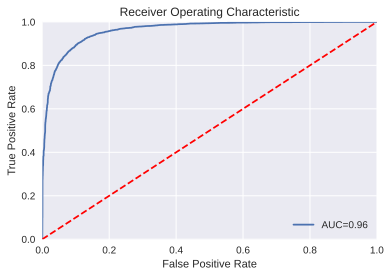

In [ ]:
count_rocauc_classif(sgd_model, test_tfidf, test_label)

**ROC AUC cross-validation**

-- Epoch 1
Norm: 79.32, NNZs: 112503, Bias: 0.138744, T: 7932, Avg. loss: 0.394000
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 66.29, NNZs: 127767, Bias: 0.085113, T: 15864, Avg. loss: 0.138496
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 63.53, NNZs: 133107, Bias: 0.113492, T: 23796, Avg. loss: 0.104568
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 62.25, NNZs: 135876, Bias: 0.060537, T: 31728, Avg. loss: 0.085730
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 61.60, NNZs: 137043, Bias: 0.068036, T: 39660, Avg. loss: 0.074404
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 61.22, NNZs: 138002, Bias: 0.066284, T: 47592, Avg. loss: 0.066578
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
Norm: 78.91, NNZs: 111465, Bias: 0.008774, T: 7933, Avg. loss: 0.389558
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 65.60, NNZs: 126926, Bias: 0.052726, T: 15866, Avg. loss: 0.131798
Total training time: 0.03 seconds.
-- Ep

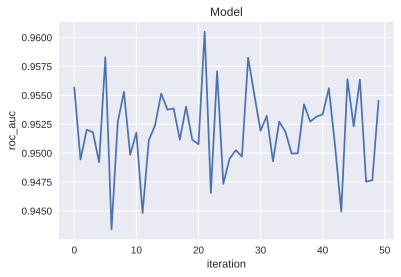

In [ ]:
calc_rocauc_cross_val(sgd_model, test_tfidf, test_label)

**Conclusion**

•	After tuning the hyperparameters, the values changed slightly, increased by thousandths
•	The values of the metrics decreased slightly compared to the logistic regression.
* Simple accuracy gives an excellent result-0.897, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.897, which is good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.96 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.

## **SVM**

### **Simple model**

In [ ]:
svc_model = LinearSVC()
svc_model.fit(train_tfidf, train_label)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
preds = svc_model.predict(test_tfidf)

**Words importance**

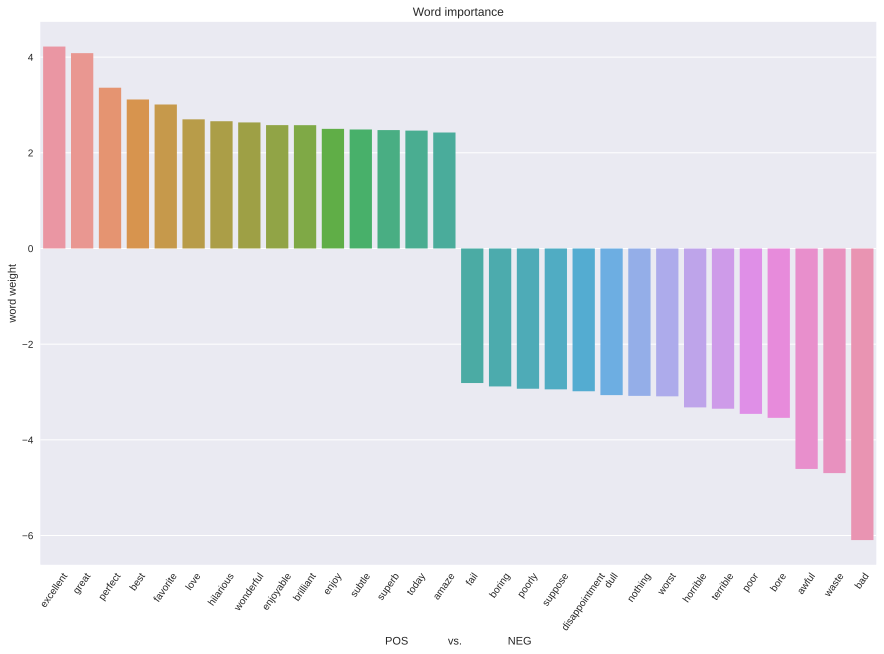

In [ ]:
get_word_importance(svc_model ,tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.

* Looking at the positive and negative words, it can be noted that the logistic regression copes well with the task.
* In *positive* comments, the words **excellent, great, perfect** play more weight.
* In *negative* comments, the words words **bad, waste, awful** play a greater role.


**Quality assessment**

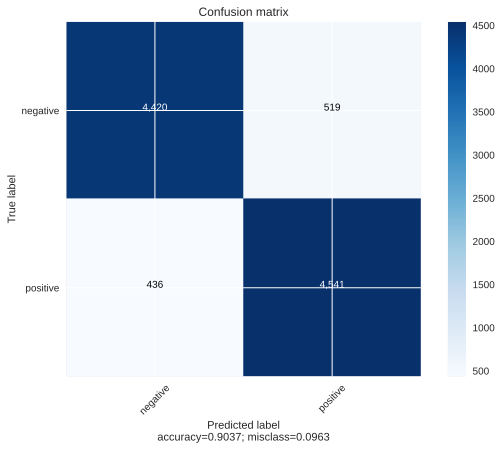

Accuracy: 0.90369 
Balanced accuracy: 0.90366 
Multiclass f1-score: 
    micro: 0.90369 
    macro: 0.90368 
    weighted: 0.90368


Classification report:

              precision    recall  f1-score   support

           0    0.91021   0.89492   0.90250      4939
           1    0.89743   0.91240   0.90485      4977

    accuracy                        0.90369      9916
   macro avg    0.90382   0.90366   0.90368      9916
weighted avg    0.90380   0.90369   0.90368      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96702 
    weighted: 0.96702


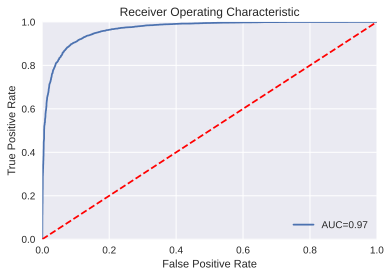

In [ ]:
count_rocauc_classif(svc_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9525596078789108


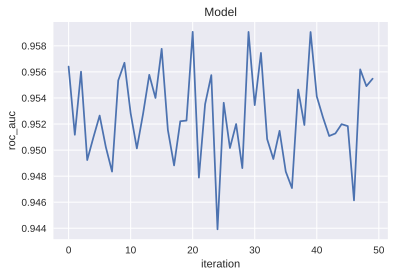

In [ ]:
calc_rocauc_cross_val(svc_model, test_tfidf, test_label)

**Conclusion**

* The values of the metrics increased slightly compared to the SGDClassifier.
* Simple accuracy gives an excellent result-0.903, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.903, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.



### **Hyperparameters tuning**

In [ ]:
params = {
    'penalty' : ['l1', 'l2'],
    'tol': [1e-3, 1e-4],
    'C': [0.1, 1, 10, 50,  100]
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
svcm = LinearSVC()
gd = GridSearchCV(svcm,
                  params,
                  cv=rskf, 
                  scoring='f1',
                  n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 50, 100], 'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 1, 'penalty': 'l2', 'tol': 0.001}

**Now we will train the model with the selected parameters**

In [ ]:
svc_model = LinearSVC(C=1, penalty='l2', tol=0.001)

In [ ]:
%%time
svc_model.fit(train_tfidf, train_label)

CPU times: user 1.15 s, sys: 4.49 ms, total: 1.16 s
Wall time: 1.17 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

In [ ]:
preds = svc_model.predict(test_tfidf)

**Words importance**

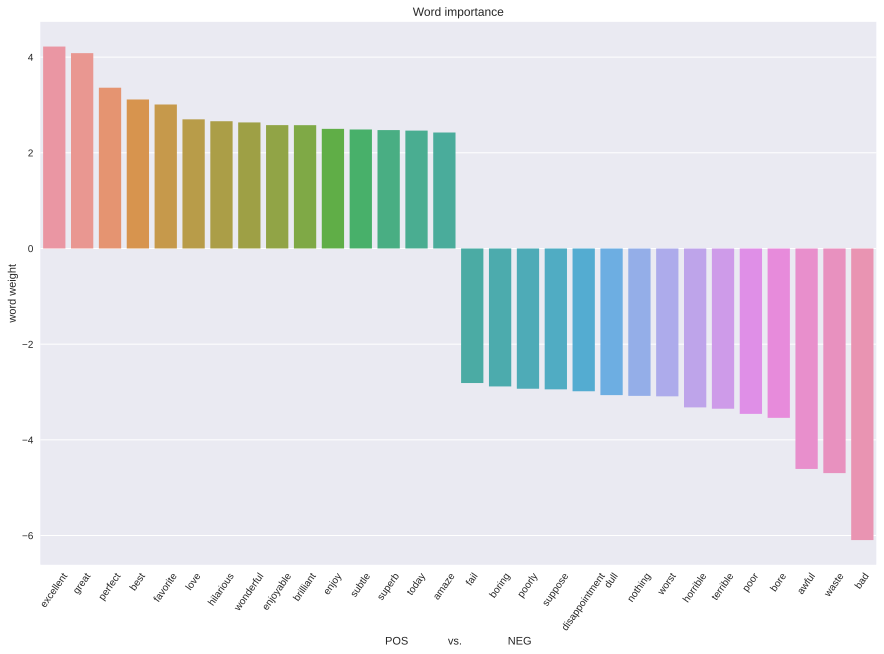

In [ ]:
get_word_importance(svc_model ,tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that the logistic regression copes well with the task.
* In *positive* comments, the words **excellent, great, perfect** play more weight.
* In *negative* comments, the words words **bad, waste, awful** play a greater role.


**Quality assessment**

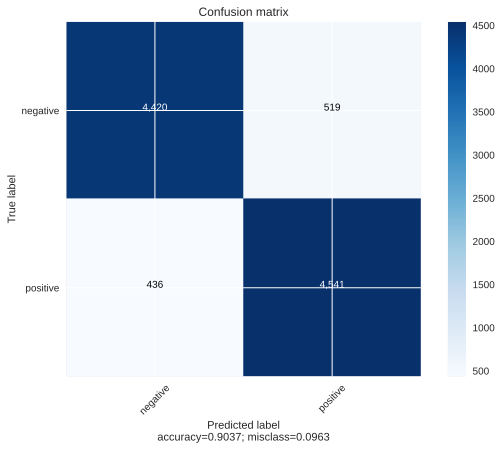

Accuracy: 0.90369 
Balanced accuracy: 0.90366 
Multiclass f1-score: 
    micro: 0.90369 
    macro: 0.90368 
    weighted: 0.90368


Classification report:

              precision    recall  f1-score   support

           0    0.91021   0.89492   0.90250      4939
           1    0.89743   0.91240   0.90485      4977

    accuracy                        0.90369      9916
   macro avg    0.90382   0.90366   0.90368      9916
weighted avg    0.90380   0.90369   0.90368      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.96702 
    weighted: 0.96702


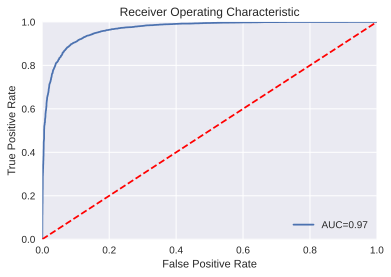

In [ ]:
count_rocauc_classif(svc_model, test_tfidf, test_label)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9526884839363011


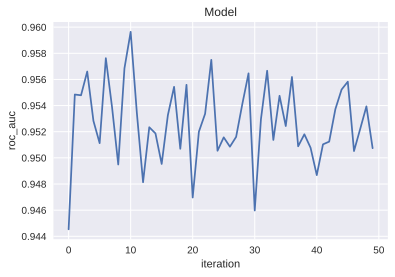

In [ ]:
calc_rocauc_cross_val(svc_model, test_tfidf, test_label)

**Conclusion**

*	After tuning the hyperparameters, the values don't changed.
*	The values of the metrics increased slightly compared to the SGDClassifier.
* Simple accuracy gives an excellent result-0.903, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.903, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 1. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.97 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.95.



### **Naive Bayes**

**MultinomialNB** implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

### **Simple model**

In [ ]:
mnb_model = MultinomialNB()
mnb_model.fit(train_tfidf, train_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
preds = mnb_model.predict(test_tfidf)

**Words importance**

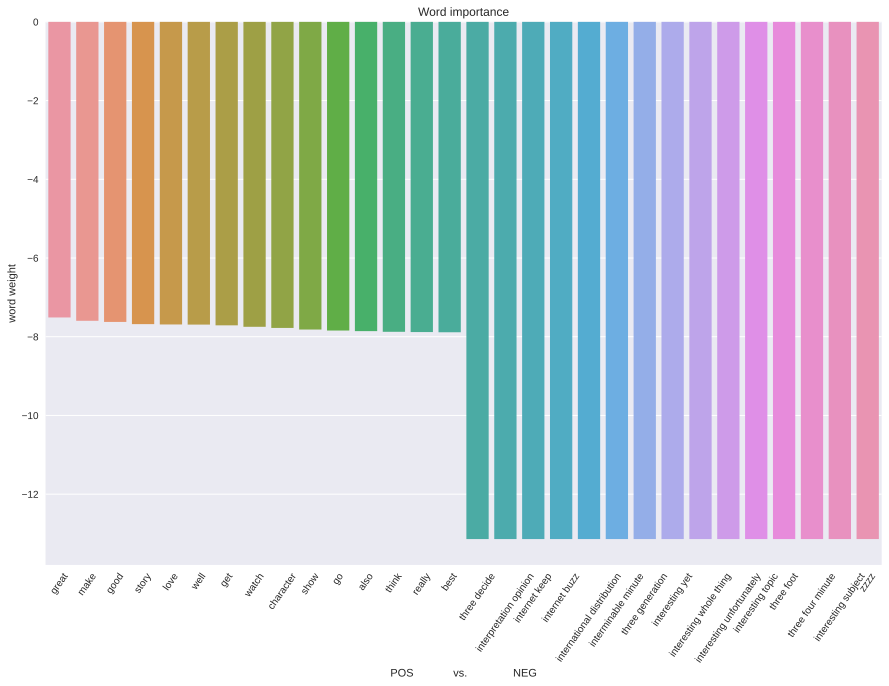

In [ ]:
get_word_importance(mnb_model ,tfidf, 15)

**Conclusion**

* Looking at the positive and negative words, it can be noted that Naive Bayes gave more weight to strange and unusual words and phrases in negative comments.
* In *positive* comments, the words **great, make, good** play more weight.
* In *negative* comments, the words words **interesting subject, three four minute** play a greater role.


**Quality assessment**

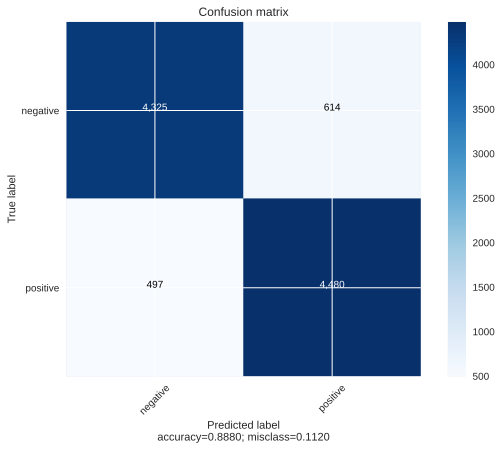

Accuracy: 0.88796 
Balanced accuracy: 0.88791 
Multiclass f1-score: 
    micro: 0.88796 
    macro: 0.88793 
    weighted: 0.88794


Classification report:

              precision    recall  f1-score   support

           0    0.89693   0.87568   0.88618      4939
           1    0.87947   0.90014   0.88968      4977

    accuracy                        0.88796      9916
   macro avg    0.88820   0.88791   0.88793      9916
weighted avg    0.88816   0.88796   0.88794      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.95389 
    weighted: 0.95389


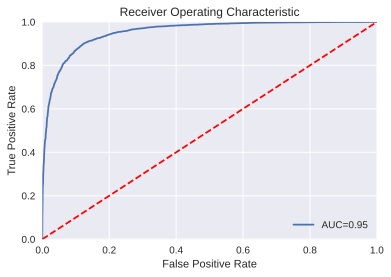

In [ ]:
count_roc_auc(mnb_model, test_tfidf, test_label, num_classes,classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9418741760665021


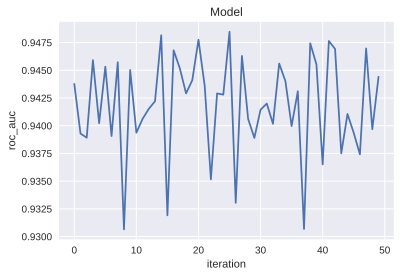

In [ ]:
calc_rocauc_cross_val(mnb_model, test_tfidf, test_label)

**Conclusion**

*	The values of the metrics decreased slightly compared to the SVM.
* Simple accuracy gives an excellent result-0.89, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.89, which is good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.95 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.94.

### **Hyperparameters tuning**

In [ ]:
params = {
    'alpha':  [0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'fit_prior':  [True, False],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
mnb = MultinomialNB()
gd = GridSearchCV(mnb,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(train_tfidf, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': [0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'alpha': 0.5, 'fit_prior': True}

**Now we will train the model with the selected parameters**

In [ ]:
mnb_model = MultinomialNB(alpha=0.5,
                         fit_prior=True)

In [ ]:
mnb_model.fit(train_tfidf, train_label)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [ ]:
%%time
preds = mnb_model.predict(test_tfidf)

CPU times: user 35.6 ms, sys: 1.18 ms, total: 36.8 ms
Wall time: 40.1 ms


**Words importance**

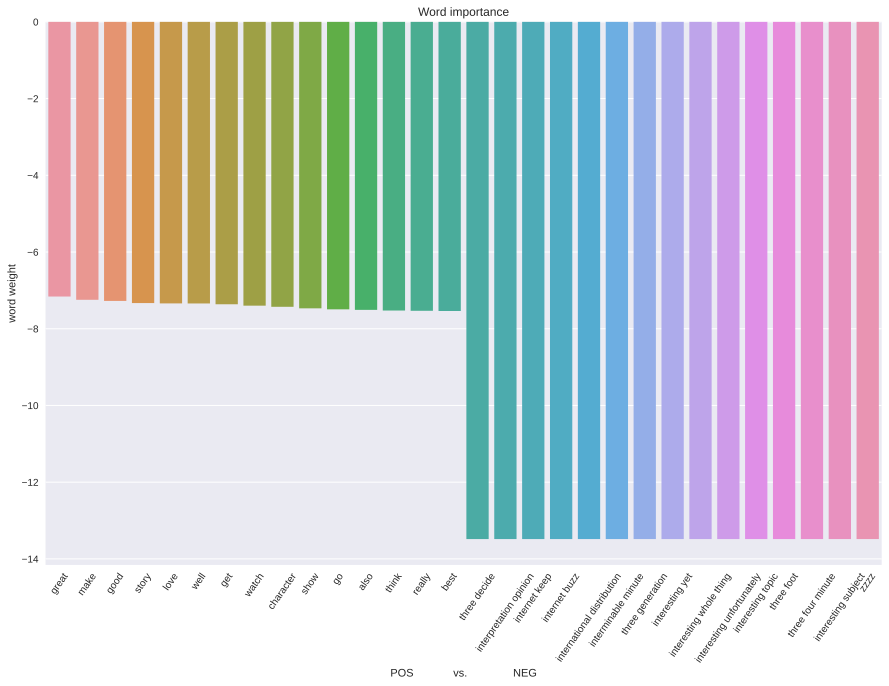

In [ ]:
get_word_importance(mnb_model ,tfidf, 15)

**Conclusion**

* After tuning the hyperparameters, it can be noted that the same words play the greatest weight in negative and positive comments.
* Looking at the positive and negative words, it can be noted that Naive Bayes gave more weight to strange and unusual words and phrases in negative comments.
* In *positive* comments, the words **great, make, good** play more weight.
* In *negative* comments, the words words **interesting subject, three four minute** play a greater role.


**Quality assessment**

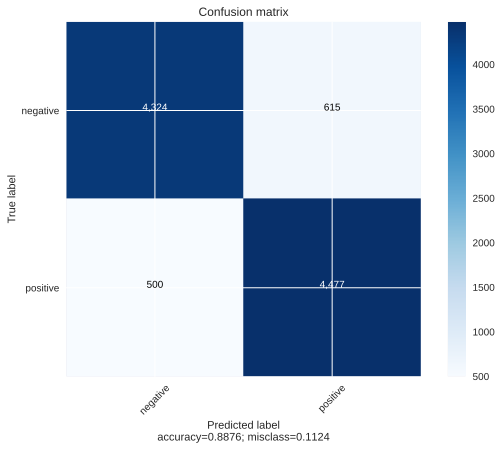

Accuracy: 0.88756 
Balanced accuracy: 0.88751 
Multiclass f1-score: 
    micro: 0.88756 
    macro: 0.88753 
    weighted: 0.88754


Classification report:

              precision    recall  f1-score   support

           0    0.89635   0.87548   0.88579      4939
           1    0.87922   0.89954   0.88926      4977

    accuracy                        0.88756      9916
   macro avg    0.88779   0.88751   0.88753      9916
weighted avg    0.88775   0.88756   0.88754      9916



In [ ]:
calc_metrics(test_label, preds)

**ROC AUC**

ROC AUC: 
    macro: 0.95457 
    weighted: 0.95457


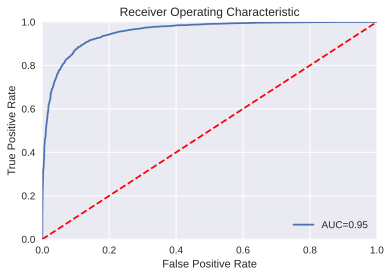

In [ ]:
count_roc_auc(mnb_model, test_tfidf, test_label, num_classes,classes_names)

**ROC AUC Cross-Validation**

ROC AUC mean score after cross-val:    0.9415068058264809


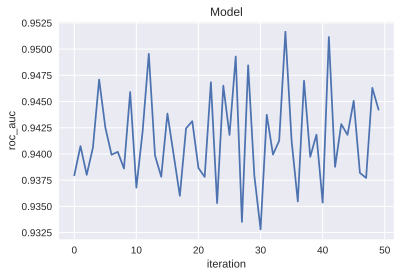

In [ ]:
calc_rocauc_cross_val(mnb_model, test_tfidf, test_label)

**Conclusion**

*	After tuning the hyperparameters, the values changed slightly, increased by thousandths
*	The values of the metrics decreased slightly compared to other models.
* Simple accuracy gives an excellent result-0.887, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.887, which is very good.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes very good. The values of the classes are close to 0.9. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an almost perfect result of training a logistic regression model. (0.95 is the result) 
* However, the cross validation shows that the roc auc score decreased slightly to 0.94.


# **General conclusion**

* Speaking about the pre-processing of the text, the main stages of cleaning were summed up (removing punctuation, stop words, etc., stemming and Lemmatization). It would also be possible to correct spelling errors in the text, but the power of my computer was not enough to process the entire text in an acceptable time, but the quality of the models during processing, without this correction, was high. (*f1-score* = ~0.9, *ROC AUC* = ~0.96)

* Comparing stemming and Lemmatization with each other, I can say that the results of the metrics turned out to be very similar to each other, but still, stemming had higher results than lematization by thousandths of a fraction.  
 **Example:** SVM model --> Scores: 
 
    *f1* (Stemming)
              0 class = 0.904  
              1 class = 0.906
    *f1* (Lemmatization)
          0 class = 0.902  
          1 class = 0.904

* Looking at the importance of the words of all models, the naive Bayes algorithm coped with this task the worst by determining negative comments. This can be seen both by the words (Example: "zzzz") and by the metrics (They are high ( ~0.88), but not worse than other models). In other models, the correct words played an important role. (Example: *great* = positive, *bad* = negative)

* In general, the *LinearSVM algorithm* coped much better with this data set (I compare 3 algorithms: GSD, SVM and Naive Bayes). All metrics in general for all 2 classes showed excellent results.
* I mainly focused on the "f1-score" metric, since it is something in between recall and precision. It was more convenient to focus on its values.  Also, accuracy and balanced accuracy show the same results (similar and high).

* The *Multinomial Naive Bayes* algorithm performed much worse, this can be seen both by the f1-score metric = ~0.886 and by the roc-auc = ~0.94.

# **Additional segment**

* In this part of the laptop, I decided to try to translate words into vectors using word2vec and see the results on the logistic regression.

* Many machine learning algorithms requires the input features to be represented as a fixed-length feature vector. When it comes to texts, one of the most common fixed-length features is one hot encoding methods such as bag of words or tf-idf. The advantage of these approach is that they have fast execution time, while the main drawback is they lose the ordering & semantics of the words.

* The motivation behind converting text into semantic vectors (such as the ones provided by Word2Vec) is that not only do these type of methods have the capabilities to extract the semantic relationships (e.g. the word powerful should be closely related to strong as oppose to another word like bank), but they should be preserve most of the relevant information about a text while having relatively low dimensionality.

* I loaded the already processed text from the variant with stamping, since it showed the best results on this data set in the models.

In [ ]:
df_add.head(2)

review  sentiment
0  review mention watch oz episod hook right exac...          1
1  wonder littl product film techniqu unassum old...          1

## **Split**

In [ ]:
(trainData, 
 testData, 
 train_label, 
 test_label) = train_test_split(df_add.drop('sentiment',
                                            axis=1),
                                            df_add['sentiment'],
                                            stratify=df_add['sentiment'],
                                            test_size=0.2,
                                            random_state=42)

print('Size of train set:', trainData.shape)
print('Size of test set:', testData.shape)

print('\nClass distribution on train:',
      train_label.value_counts(normalize=True),
      '\nClass distribution on test:', 
      test_label.value_counts(normalize=True),
      sep='\n')

Size of train set: (39661, 1)
Size of test set: (9916, 1)

Class distribution on train:
1    0.501878
0    0.498122
Name: sentiment, dtype: float64

Class distribution on test:
1    0.501916
0    0.498084
Name: sentiment, dtype: float64


## **Word2Vec**

In [ ]:
from gensim.models import Word2Vec
import gensim
import gensim.downloader as gensim_api

Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space. That can be done using 2 different approaches: starting from a single word to predict its context (Skip-gram) or starting from the context to predict a word (Continuous Bag-of-Words).

* Here I create a words corpus from my dataset in order to implement my own word2vec model.
* Instead of using a pre-trained model, I am going to fit my own Word2Vec on the training data corpus with gensim. Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams.

In [ ]:
corpus = df_add["review"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

**Features creation**

In [ ]:
from tqdm import tqdm

def createFeatureVector(words, model, num_features):
    #initialize a 1D array with length as num of features of word2vec model chosen by us. 
    #Here it is 250.
    featVector = np.zeros((num_features,),dtype="float32")
    
    nWords = 0
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, as set is faster
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word and add it to the feature vector to get the total sum of feature vectors of the
    #entire review
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featVector = np.add(featVector,model[word])
            
    # Divide the result by the number of words to get the average of the feature vectors of 
    #all words in the review
    if(nWords != 0):
        featVector = np.divide(featVector,nWords)
    return featVector

#calculates the average of the feature vectors for each review using the word2vec values assigned for 
#each word
def avgFeatureVectors(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(createFeatureVector(sentence, model, num_features)) 
    return overallFeatureVectors

### **1st w2v model**

**Train word2vec model**

When fitting the Word2Vec, you need to specify:  

* the target size of the word vectors, I’ll use 100;
* the window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
* the training algorithm, I’ll use skip-grams (sg=1) as in general it has better results.

In [ ]:
model1 = gensim.models.word2vec.Word2Vec(lst_corpus, size=100, window=8, workers=8, min_count=1, sg=1, iter=30)
# summarize vocabulary size in model
words = list(model1.wv.vocab)
print('Vocabulary size: %d' % len(words))

print(model1.wv.index2word[0], model1.wv.index2word[1], model1.wv.index2word[2])

Vocabulary size: 123619
good make charact


In [ ]:
train_vect = avgFeatureVectors(trainData['review'], model1, 100 )
test_vect = avgFeatureVectors(testData['review'], model1, 100 )

100%|██████████| 9916/9916 [06:04<00:00, 27.19it/s]


**Look at the results on Logistic regression model:**

Selection of optimal hyperparameters

In [ ]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(train_vect, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 0.5, 'tol': 0.05}

**Now we will train the model with the selected parameters:**

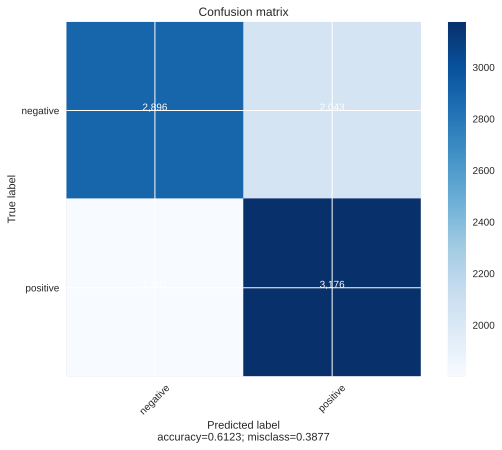

Accuracy: 0.61234 
Balanced accuracy: 0.61224 
Multiclass f1-score: 
    micro: 0.61234 
    macro: 0.61203 
    weighted: 0.61208


Classification report:

              precision    recall  f1-score   support

           0    0.61656   0.58635   0.60108      4939
           1    0.60855   0.63814   0.62299      4977

    accuracy                        0.61234      9916
   macro avg    0.61255   0.61224   0.61203      9916
weighted avg    0.61254   0.61234   0.61208      9916



In [ ]:
clf = LogisticRegression(C=0.5,
                         tol=0.05)
clf.fit(train_vect, train_label)
pred = clf.predict(test_vect)
calc_metrics(test_label, pred)

**ROC AUC**

In [ ]:
classes_names = ['negative', 'positive']
num_classes = 2

ROC AUC: 
    macro: 0.64924 
    weighted: 0.64924


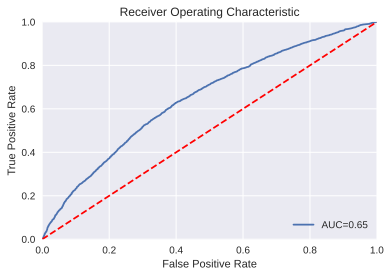

In [ ]:
count_roc_auc(clf, test_vect, test_label, num_classes, classes_names)

**Conclusion**

* Simple accuracy gives an average result, just above 0.5, it's 0.6, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.6.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes higher than 0.5, also about 0.6, which is not very good. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an average result of training a logistic regression model. (0.65 is the result) 

### **Next variant of word2vec model with other parametrs:**

* Specifing the Word2Vec params., I set
the target size of the word vectors = 300 now

**Train word2vec model**

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=10, min_count=1, sg=1, iter=30)

In [ ]:
nlp.most_similar(['good'])

[('great', 0.7355854511260986),
 ('realli', 0.6873623132705688),
 ('bad', 0.6772997379302979),
 ('decent', 0.6564591526985168),
 ('chasesuspens', 0.6486315727233887),
 ('animalsfx', 0.6482129693031311),
 ('charactersgood', 0.6465696096420288),
 ('nibbi', 0.644791841506958),
 ('nice', 0.6440504789352417),
 ('easyit', 0.643226146697998)]

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in nlp.wv.vocab]
    return np.mean(nlp[doc], axis=0)

In [ ]:
trainData['doc_vector'] = trainData.review.apply(document_vector)
testData['doc_vector'] = testData.review.apply(document_vector)

In [ ]:
X_train = list(trainData['doc_vector'])
X_test = list(testData['doc_vector'])

**Look at the results on Logistic regression model:**

In [ ]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(X_train, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 0.5, 'tol': 0.05}

**Now we will train the model with the selected parameters**

In [ ]:
clf = LogisticRegression(C=0.5,
                         tol=0.05)

In [ ]:
clf.fit(X_train, train_label)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.05, verbose=0,
                   warm_start=False)

In [ ]:
%%time
pred = clf.predict(X_test)

CPU times: user 26.2 ms, sys: 24.7 ms, total: 50.9 ms
Wall time: 27.7 ms


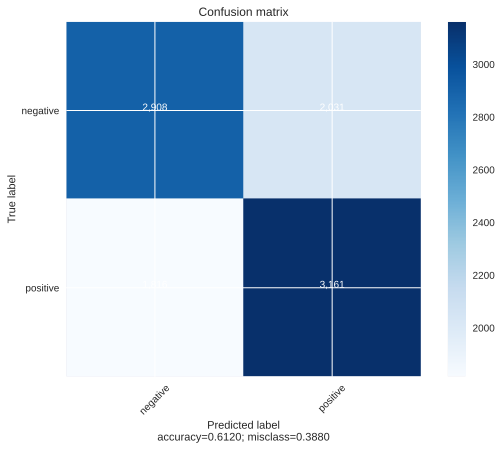

Accuracy: 0.61204 
Balanced accuracy: 0.61195 
Multiclass f1-score: 
    micro: 0.61204 
    macro: 0.61179 
    weighted: 0.61183


Classification report:

              precision    recall  f1-score   support

           0    0.61558   0.58878   0.60188      4939
           1    0.60882   0.63512   0.62169      4977

    accuracy                        0.61204      9916
   macro avg    0.61220   0.61195   0.61179      9916
weighted avg    0.61219   0.61204   0.61183      9916



In [ ]:
calc_metrics(test_label, pred)

ROC AUC: 
    macro: 0.65192 
    weighted: 0.65192


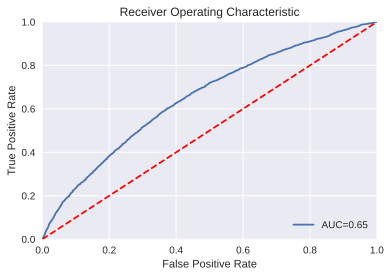

In [ ]:
count_roc_auc(clf, X_test, test_label, num_classes, classes_names)

**Conclusion**

* Simple accuracy gives an average result, just above 0.5, it's 0.6, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.6.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes higher than 0.5, also about 0.6, which is not very good. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an average result of training a logistic regression model. (0.65 is the result) 

### **Next variant of LOADED word2vec model:**

In [ ]:
nlp2 = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in nlp2.wv.vocab]
    return np.mean(nlp2[doc], axis=0)

In [ ]:
trainData['doc_vec'] = trainData['review'].apply(document_vector)
testData['doc_vec'] = testData['review'].apply(document_vector)

In [ ]:
X_train = list(trainData['doc_vec'])
X_test = list(testData['doc_vec'])

**Look at the results on Logistic regression model:**

Selection of optimal hyperparameters

In [ ]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [ ]:
gd.fit(X_train, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
gd.best_params_

{'C': 5, 'tol': 0.1}

**Now we will train the model with the selected parameters**

In [ ]:
clf = LogisticRegression(C=5,
                         tol=0.1)

clf.fit(X_train, train_label) 

pred = clf.predict(X_test)

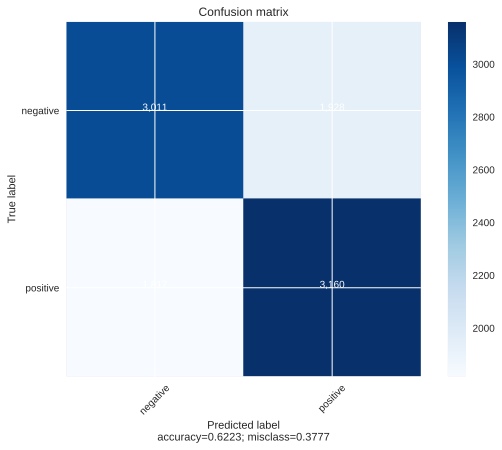

Accuracy: 0.62233 
Balanced accuracy: 0.62228 
Multiclass f1-score: 
    micro: 0.62233 
    macro: 0.62224 
    weighted: 0.62226


Classification report:

              precision    recall  f1-score   support

           0    0.62365   0.60964   0.61657      4939
           1    0.62107   0.63492   0.62792      4977

    accuracy                        0.62233      9916
   macro avg    0.62236   0.62228   0.62224      9916
weighted avg    0.62236   0.62233   0.62226      9916



In [ ]:
calc_metrics(test_label, pred)

ROC AUC: 
    macro: 0.66801 
    weighted: 0.66801


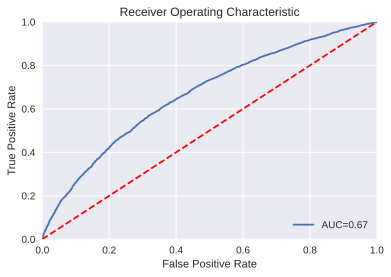

In [ ]:
count_roc_auc(clf, X_test, test_label, num_classes, classes_names)

**Conclusion**

* Simple accuracy gives an average result, just above 0.5, it's 0.6, but you should not believe this estimate 100 percent, so it's worth looking at a balanced accuracy.
* Balanced Accuracy tries to account for the imbalance in the classes and outputs a value of - 0.6.
* However, it is worth noting that our class is quite balanced and the accuracy does not differ much.
* My classifier identifies both classes higher than 0.5, also about 0.6, which is not very good. This fact is also confirmed by the *f1-score* metric.
* The ROC AUC metric shows an average result of training a logistic regression model. (0.67 is the result) 

## **General conclusion 2**

* In general, it is clear that the Word2Vec strategy coped significantly worse with this dataset than tfidf. Each approach has its own disadvantages and advantages, which were described above.
* In this additional part, 3 w2v models were demonstrated (two filled with words from the presented dataset with different parameters and one-a downloaded model from the Internet with a huge dictionary). However, but one attempt did not raise the values of the metrics to a high level. This gave me the idea that the dataset needs to be better processed and get rid of spelling errors in words. What can be checked on a more powerful machine.